# Benchmark for Clustering

In [39]:
"""Load/import helper functions"""

import time
import random
from LocalPopular import extract_labels_from_communities, time_tester, calculate_scores_clustering

from LocalStable import locally_stable_clustering_with_euclid_graphs

from GraphFunctions import generate_agents, calculate_euclidian_relationships, create_graph, \
    my_make_circles, create_graphs_euclid, create_graphs_kNN, \
    generate_graph,create_graphs_hop_distance, create_graphs_hop_distance_abs,randomize_graph_pos_labels

from PlotHelperFunctions import plot_clustering, plot_stuff

from sklearn.cluster import KMeans, DBSCAN
from sklearn.datasets import make_moons, load_breast_cancer, load_iris
from sklearn.metrics import rand_score
import numpy as np
import networkx as nx
from scipy.spatial import distance

from community_detection.leiden import leiden
from community_detection.louvain import louvain
from community_detection.quality_functions import CPM, Modularity



## Create Graphs

In [40]:
repetitions = 1    #Number of random isomorph permutation for each graph


moon_agents,moon_truth = make_moons(n_samples=300, noise=0.05)
moon_perm_agents = []
moon_perm_truth = []
for i in range(repetitions):
    g,t = randomize_graph_pos_labels(moon_agents,moon_truth)
    moon_perm_agents += [g]
    moon_perm_truth += [t]



circle_agents, circle_truth = my_make_circles(300)

circle_perm_agents = []
circle_perm_truth = []
for i in range(repetitions):
    g,t = randomize_graph_pos_labels(circle_agents,circle_truth)
    circle_perm_agents += [g]
    circle_perm_truth += [t]

cancer = load_breast_cancer()

cancer_agents = cancer['data']
cancer_truth = cancer['target']

cancer_perm_agents = []
cancer_perm_truth = []
for i in range(repetitions):
    g,t = randomize_graph_pos_labels(cancer_agents,cancer_truth)
    cancer_perm_agents += [g]
    cancer_perm_truth += [t]

iris = load_iris()
iris_agents = iris['data']
iris_truth = iris['target']


iris_perm_agents = []
iris_perm_truth = []
for i in range(repetitions):
    g,t = randomize_graph_pos_labels(iris_agents,iris_truth)
    iris_perm_agents += [g]
    iris_perm_truth += [t]


## Run the algorithms


In [41]:
import itertools
import timeit

f = 0.2   #f-bound
e = 0.3   #e-bound

data = [ moon_perm_agents,circle_perm_agents,cancer_perm_agents,iris_perm_agents]
expected_clusters = [2,3,2,3]
graph_names = ['Moons','My 3 Circles', 'Cancer', 'Iris']
graph_truths =  [moon_perm_truth,circle_perm_truth,cancer_perm_truth,iris_perm_truth]


kmeans = lambda agents, clusters: KMeans(n_clusters = clusters).fit_predict(agents)
dbscan = lambda agents, clusters: DBSCAN(eps=0.2, min_samples=5).fit_predict(agents)

kmeans_out = None
dbscan_out = None

lp_a_b =lambda agents, initial_clustering, pre, always_allow_exit: locally_stable_clustering_with_euclid_graphs(agents, f, e, initial_clustering,always_allow_exit,mode='B',pre=pre)
lp_a_f =lambda agents, initial_clustering, pre, always_allow_exit: locally_stable_clustering_with_euclid_graphs(agents, f, e, initial_clustering, always_allow_exit, mode='F',pre=pre)
lp_a_e =lambda agents, initial_clustering, pre, always_allow_exit: locally_stable_clustering_with_euclid_graphs(agents, f, e, initial_clustering, always_allow_exit, mode='E',pre=pre)

algorithms = [ kmeans, dbscan,lp_a_b,lp_a_f,lp_a_e]
algo_names = [ 'kmeans', 'dbscan','LP (Balanced) Heuristic',\
               'LP (Friend-Oriented) Heuristic','LP (Enemy-Averse) Heuristic']
is_lp_heuristic = [False,False,True, True, True]

collected_data = {}

for ((graph, g_name,clusters,truth), (algo, a_name,lp_heuristic)) in \
    itertools.product(zip(data, graph_names, expected_clusters,graph_truths), zip(algorithms, algo_names,is_lp_heuristic)):

        
    agents = graph

    if lp_heuristic:
        # start with everyone alone
        a_name_modified = a_name + ' starting with everyone alone'
        print(f"Running {a_name_modified} on {g_name} … ", end='')
        always_allow_exit = False
        test_callable = lambda a: list(algo(a,len(agents[0]),None,always_allow_exit).values())
        times,outputs = time_tester(test_callable,graph)
        avg_time = sum(times)/len(times)
        scores = calculate_scores_clustering(outputs,truth,agents)
        scores['Time'] = avg_time

        collected_data[(a_name_modified,g_name)] = scores
        print(f"execution time: ~ {avg_time:.6f} seconds.")
        for score_name in scores.keys():
            print(score_name,": ~",scores.get(score_name))

        # start with random clustering 

        a_name_modified = a_name + ' starting with predicted number of clusters'
        print(f"Running {a_name_modified} on {g_name} … ", end='')
        always_allow_exit = False
        test_callable = lambda a: list(algo(a,clusters,None,always_allow_exit).values())
        times,outputs = time_tester(test_callable,graph)
        avg_time = sum(times)/len(times)
        scores = calculate_scores_clustering(outputs,truth,agents)
        scores['Time'] = avg_time

        collected_data[(a_name_modified,g_name)] = scores
        print(f"execution time: ~ {avg_time:.6f} seconds.")
        for score_name in scores.keys():
            print(score_name,": ~",scores.get(score_name))


        # start with the output of k-means
        a_name_modified = a_name + ' starting with the output of k-means'
        print(f"Running {a_name_modified} on {g_name} … ", end='')
        always_allow_exit = False
        test_callable = lambda a: list(algo(a,clusters,kmeans,always_allow_exit).values())
        times,outputs = time_tester(test_callable,graph)
        avg_time = sum(times)/len(times)
        scores = calculate_scores_clustering(outputs,truth,agents)

        rand_score_with_init = sum(rand_score(out, k) for out, k in zip(outputs, kmeans_out)) / len(outputs)
        scores['Rand Score with initial clustering'] = rand_score_with_init
        
        scores['Time'] = avg_time

        collected_data[(a_name_modified,g_name)] = scores
        print(f"execution time: ~ {avg_time:.6f} seconds.")
        for score_name in scores.keys():
            print(score_name,": ~",scores.get(score_name))

        # start with the output of dbscan
        a_name_modified = a_name + ' starting with the output of dbscan'
        print(f"Running {a_name_modified} on {g_name} … ", end='')
        always_allow_exit = False
        test_callable = lambda a: list(algo(a,clusters,dbscan,always_allow_exit).values())
        times,outputs = time_tester(test_callable,graph)
        avg_time = sum(times)/len(times)
        scores = calculate_scores_clustering(outputs,truth,agents)

        rand_score_with_init = sum(rand_score(out, db) for out, db in zip(outputs, dbscan_out)) / len(outputs)
        scores['Rand Score with initial clustering'] = rand_score_with_init
           
        scores['Time'] = avg_time

        collected_data[(a_name_modified,g_name)] = scores
        print(f"execution time: ~ {avg_time:.6f} seconds.")
        for score_name in scores.keys():
            print(score_name,": ~",scores.get(score_name))

            
    else:

        print(f"Running {a_name} on {g_name} … ", end='')
        test_callable = lambda a : algo(a, clusters)
            
        times,outputs = time_tester(test_callable,graph)
        if(algo == kmeans):
            kmeans_out = outputs
        if(algo == dbscan):
            dbscan_out = outputs
        avg_time = sum(times)/len(times)
        scores = calculate_scores_clustering(outputs,truth,agents)
        scores['Time'] = avg_time
        
        collected_data[(a_name,g_name)] = scores
        print(f"execution time: ~ {avg_time:.6f} seconds.")
        for score_name in scores.keys():
            print(score_name,": ~",scores.get(score_name))

Running kmeans on Moons … execution time: ~ 0.003187 seconds.
Rand Index : ~ 0.6204236343366778
Silhouette Score : ~ 0.4863972678704592
Davies Bouldin Score : ~ 0.7833196950444772
Time : ~ 0.0031872999970801175
Running dbscan on Moons … execution time: ~ 0.001733 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.3235057983239544
Davies Bouldin Score : ~ 1.182781469729954
Time : ~ 0.0017333999858237803
Running LP (Balanced) Heuristic starting with everyone alone on Moons … execution time: ~ 3.849903 seconds.
Rand Index : ~ 0.6440579710144928
Silhouette Score : ~ 0.4666029747176353
Davies Bouldin Score : ~ 0.7003047216907065
Time : ~ 3.849902899994049
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.307394 seconds.
Rand Index : ~ 0.7441471571906354
Silhouette Score : ~ 0.46795107681827547
Davies Bouldin Score : ~ 0.826478611833155
Time : ~ 0.3073941000038758
Running LP (Balanced) Heuristic starting with the output of k-means on Mo

KeyboardInterrupt: 

## Gather the numbers

We can use the collected_data dictionairy to build a table for better comparison


In [4]:
print(collected_data)

{('kmeans', 'Moons'): {'Rand Index': np.float64(0.6204236343366778), 'Silhouette Score': np.float64(0.48747403353362595), 'Davies Bouldin Score': np.float64(0.7784901979257762), 'Time': 0.1041811999748461}, ('dbscan', 'Moons'): {'Rand Index': 1.0, 'Silhouette Score': np.float64(0.32881623165041085), 'Davies Bouldin Score': np.float64(1.1613528758358327), 'Time': 0.002279000007547438}, ('LP (Balanced) Heuristic starting with everyone alone', 'Moons'): {'Rand Index': np.float64(0.6309253065774805), 'Silhouette Score': np.float64(0.45965461723528195), 'Davies Bouldin Score': np.float64(0.7954701374206632), 'Time': 3.7482363999588415}, ('LP (Balanced) Heuristic starting with predicted number of clusters', 'Moons'): {'Rand Index': np.float64(0.7488517279821628), 'Silhouette Score': np.float64(0.4653481226128529), 'Davies Bouldin Score': np.float64(0.8246082372226138), 'Time': 0.3442341000190936}, ('LP (Balanced) Heuristic starting with the output of k-means', 'Moons'): {'Rand Index': np.flo

In [5]:
import pandas as pd
records = []
for (method, dataset), metrics in collected_data.items():
    record = {'Method': method, 'Dataset': dataset}
    record.update(metrics)
    records.append(record)

df = pd.DataFrame(records)

def sort_within_datasets(df, score_column, ascending=False):
    """
    Sort the rows within each dataset group by the given score column.

    Parameters:
    - df: pandas DataFrame containing 'Dataset' and score columns.
    - score_column: str, the column to sort by (e.g., 'Rand Index').
    - ascending: bool, whether to sort in ascending order (default: descending).

    Returns:
    - A sorted DataFrame.
    """
    return df.sort_values(by=['Dataset', score_column], ascending=[True, ascending])

# Example usage:
sorted_df = sort_within_datasets(df, 'Rand Index', ascending=False)
sorted_df

,Method,Dataset,Rand Index,Silhouette Score,Davies Bouldin Score,Time,Rand Score with initial clustering
28,kmeans,Cancer,0.750377,0.697265,0.504404,0.004150,NaN
38,LP (Enemy-Averse) Heuristic starting with ever...,Cancer,0.683340,0.666095,0.378264,26.099934,NaN
39,LP (Enemy-Averse) Heuristic starting with pred...,Cancer,0.660524,0.692122,0.479149,1.231524,NaN
40,LP (Enemy-Averse) Heuristic starting with the ...,Cancer,0.660524,0.692122,0.479149,1.026961,0.863029
31,LP (Balanced) Heuristic starting with predicte...,Cancer,0.614421,0.670595,0.488442,1.075685,NaN
32,LP (Balanced) Heuristic starting with the outp...,Cancer,0.614421,0.670595,0.488442,1.170466,0.791864
36,LP (Friend-Oriented) Heuristic starting with t...,Cancer,0.614421,0.670595,0.488442,1.033839,0.791864
30,LP (Balanced) Heuristic starting with everyone...,Cancer,0.612212,0.631753,0.403793,25.595054,NaN
34,LP (Friend-Oriented) Heuristic starting with e...,Cancer,0.605727,0.628436,0.52725,29.124366,NaN
35,LP (Friend-Oriented) Heuristic starting with p...,Cancer,0.542266,0.690205,0.441358,1.069034,NaN


C:\Users\alexg\AppData\Local\Temp\ipykernel_1508\2640985927.py:74: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plot_score_by_method(sorted_df.replace("n.A.",0), 'My 3 Circles', 'Silhouette Score')


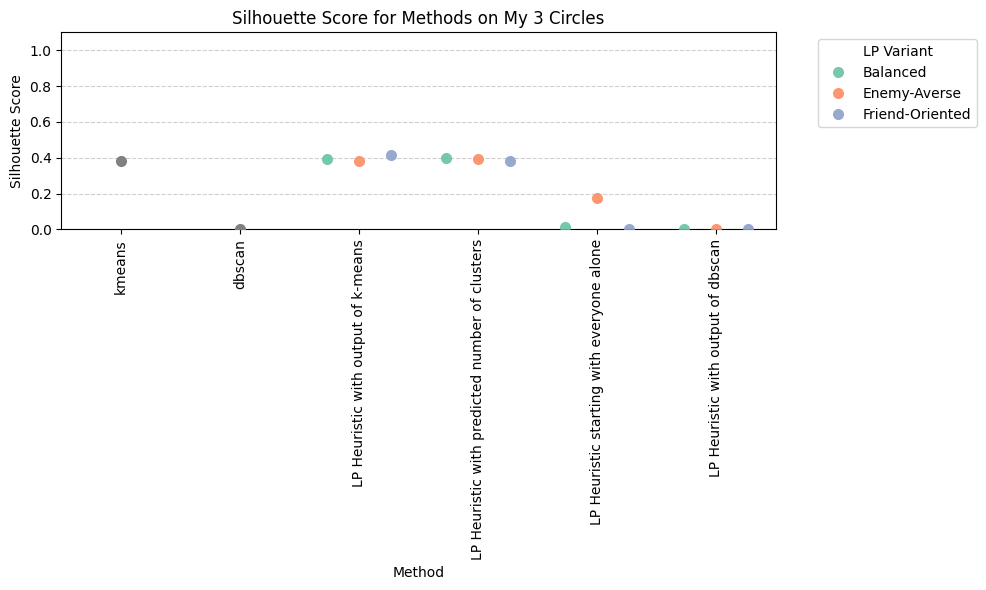

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_score_by_method(df_all, dataset_name, score_col='Rand Index', save_path=None):
    # Filter for the selected dataset
    df = df_all[df_all['Dataset'] == dataset_name].copy()

    # Define x-axis labels
    def method_group(row):
        m = row['Method']
        if 'everyone alone' in m:
            return 'LP Heuristic starting with everyone alone'
        elif 'predicted number of clusters' in m:
            return 'LP Heuristic with predicted number of clusters'
        elif 'output of k-means' in m:
            return 'LP Heuristic with output of k-means'
        elif 'output of dbscan' in m:
            return 'LP Heuristic with output of dbscan'
        elif 'kmeans' in m.lower():
            return 'kmeans'
        elif 'dbscan' in m.lower():
            return 'dbscan'
        else:
            return 'Other'

    def variant_label(row):
        m = row['Method']
        if 'Enemy-Averse' in m:
            return 'Enemy-Averse'
        elif 'Balanced' in m:
            return 'Balanced'
        elif 'Friend-Oriented' in m:
            return 'Friend-Oriented'
        else:
            return 'Other'

    df['method_group'] = df.apply(method_group, axis=1)
    df['variant'] = df.apply(variant_label, axis=1)

    one_point_methods = ['kmeans', 'dbscan']
    df_single = df[df['method_group'].isin(one_point_methods)]
    df_lp = df[~df['method_group'].isin(one_point_methods)]

    plt.figure(figsize=(10, 6))

    # First plot single point methods
    sns.stripplot(
        data=df_single, x='method_group', y=score_col,
        color='gray', size=8, jitter=False
    )

    # Then overlay LP methods with hue
    sns.stripplot(
        data=df_lp, x='method_group', y=score_col, hue='variant',
        dodge=True, size=8, palette='Set2', alpha=0.9
    )

    plt.title(f'{score_col} for Methods on {dataset_name}')
    plt.xlabel('Method')
    plt.ylabel(score_col)
    plt.ylim(0,1.1)
    plt.xticks(rotation=90)
    plt.legend(title='LP Variant', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    if save_path:
        plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
        print(f"Figure saved as {save_path}")
    plt.show()


# Call the function
plot_score_by_method(sorted_df.replace("n.A.",0), 'My 3 Circles', 'Silhouette Score')


C:\Users\alexg\AppData\Local\Temp\ipykernel_1508\3328516266.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plot_score_by_method(sorted_df.replace("n.A.",0), Dataset, score_col=score, save_path=f'/Users/User/Downloads/local-popular-main-final/0203/{Dataset}-{score}.png')


FileNotFoundError: [Errno 2] No such file or directory: '/Users/User/Downloads/local-popular-main-final/0203/Cancer-Rand Index.png'

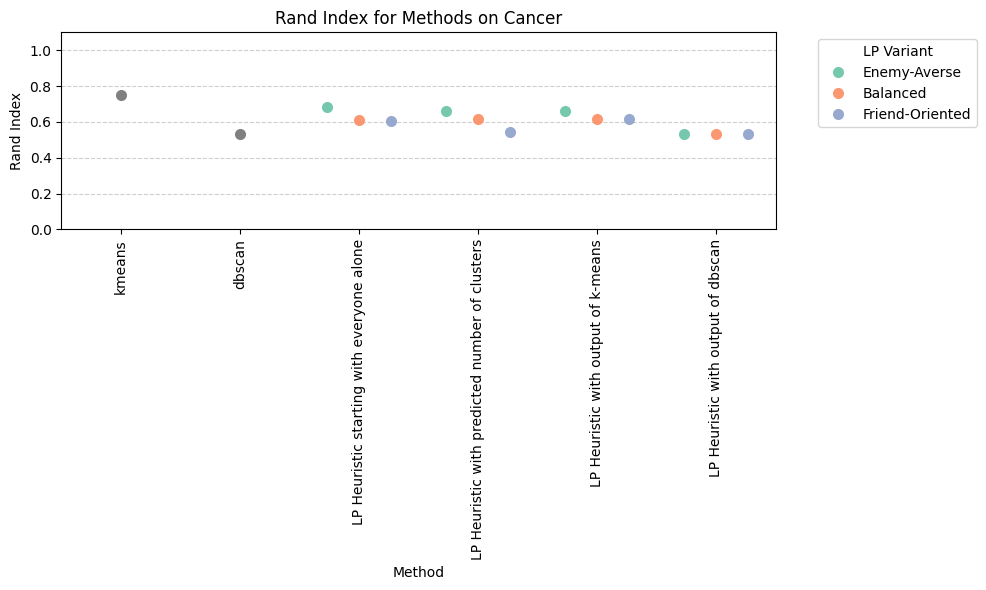

In [8]:
for Dataset in ['Cancer' ,'Iris', 'Moons' ,'My 3 Circles']:
    for score in ['Rand Index', 'Silhouette Score', 'Davies Bouldin Score']:
        plot_score_by_method(sorted_df.replace("n.A.",0), Dataset, score_col=score, save_path=f'/Users/User/Downloads/local-popular-main-final/0203/{Dataset}-{score}.png')

In [60]:
import itertools
import timeit

f = 0.2   #f-bound
e = 0.2   #e-bound

data = [ moon_perm_agents,circle_perm_agents,cancer_perm_agents,iris_perm_agents]
expected_clusters = [2,3,2,3]
graph_names = ['Moons','My 3 Circles', 'Cancer', 'Iris']
graph_truths =  [moon_perm_truth,circle_perm_truth,cancer_perm_truth,iris_perm_truth]


kmeans = lambda agents, clusters: KMeans(n_clusters = clusters).fit_predict(agents)
dbscan = lambda agents, clusters: DBSCAN(eps=0.2, min_samples=5).fit_predict(agents)

kmeans_out = None
dbscan_out = None

lp_a_b =lambda agents, initial_clustering, pre: locally_stable_clustering_with_euclid_graphs(agents, f, e, initial_clustering,mode='B',pre=pre)
lp_a_f =lambda agents, initial_clustering, pre: locally_stable_clustering_with_euclid_graphs(agents, f, e, initial_clustering,mode='F',pre=pre)
lp_a_e =lambda agents, initial_clustering, pre: locally_stable_clustering_with_euclid_graphs(agents, f, e, initial_clustering,mode='E',pre=pre)

algorithms = [ kmeans, dbscan,lp_a_b,lp_a_f,lp_a_e]
algo_names = [ 'kmeans', 'dbscan','LP (Balanced) Heuristic',\
               'LP (Friend-Oriented) Heuristic','LP (Enemy-Averse) Heuristic']
is_lp_heuristic = [False,False,True, True, True]

collected_data = {}

for ((graph, g_name,clusters,truth), (algo, a_name,lp_heuristic)) in \
    itertools.product(zip(data, graph_names, expected_clusters,graph_truths), zip(algorithms, algo_names,is_lp_heuristic)):

        
    agents = graph

    if lp_heuristic:
        # start with everyone alone
        a_name_modified = a_name + ' starting with everyone alone'
        print(f"Running {a_name_modified} on {g_name} … ", end='')
        test_callable = lambda a: list(algo(a,len(agents[0]),None).values())
        times,outputs = time_tester(test_callable,graph)
        avg_time = sum(times)/len(times)
        scores = calculate_scores_clustering(outputs,truth,agents)
        scores['Time'] = avg_time

        collected_data[(a_name_modified,g_name)] = scores
        print(f"execution time: ~ {avg_time:.6f} seconds.")
        for score_name in scores.keys():
            print(score_name,": ~",scores.get(score_name))

        # start with random clustering 

        a_name_modified = a_name + ' starting with predicted number of clusters'
        print(f"Running {a_name_modified} on {g_name} … ", end='')
        test_callable = lambda a: list(algo(a,clusters,None).values())
        times,outputs = time_tester(test_callable,graph)
        avg_time = sum(times)/len(times)
        scores = calculate_scores_clustering(outputs,truth,agents)
        scores['Time'] = avg_time

        collected_data[(a_name_modified,g_name)] = scores
        print(f"execution time: ~ {avg_time:.6f} seconds.")
        for score_name in scores.keys():
            print(score_name,": ~",scores.get(score_name))


        # start with the output of k-means
        a_name_modified = a_name + ' starting with the output of k-means'
        print(f"Running {a_name_modified} on {g_name} … ", end='')
        test_callable = lambda a: list(algo(a,clusters,kmeans).values())
        times,outputs = time_tester(test_callable,graph)
        avg_time = sum(times)/len(times)
        scores = calculate_scores_clustering(outputs,truth,agents)

        rand_score_with_init = sum(rand_score(out, k) for out, k in zip(outputs, kmeans_out)) / len(outputs)
        scores['Rand Score with initial clustering'] = rand_score_with_init
        
        scores['Time'] = avg_time

        collected_data[(a_name_modified,g_name)] = scores
        print(f"execution time: ~ {avg_time:.6f} seconds.")
        for score_name in scores.keys():
            print(score_name,": ~",scores.get(score_name))

        # start with the output of dbscan
        a_name_modified = a_name + ' starting with the output of dbscan'
        print(f"Running {a_name_modified} on {g_name} … ", end='')
        test_callable = lambda a: list(algo(a,clusters,dbscan).values())
        times,outputs = time_tester(test_callable,graph)
        avg_time = sum(times)/len(times)
        scores = calculate_scores_clustering(outputs,truth,agents)

        rand_score_with_init = sum(rand_score(out, db) for out, db in zip(outputs, dbscan_out)) / len(outputs)
        scores['Rand Score with initial clustering'] = rand_score_with_init
        
        scores['Time'] = avg_time

        collected_data[(a_name_modified,g_name)] = scores
        print(f"execution time: ~ {avg_time:.6f} seconds.")
        for score_name in scores.keys():
            print(score_name,": ~",scores.get(score_name))

            
    else:

        print(f"Running {a_name} on {g_name} … ", end='')
        test_callable = lambda a : algo(a, clusters)
            
        times,outputs = time_tester(test_callable,graph)
        if(algo == kmeans):
            kmeans_out = outputs
        if(algo == dbscan):
            dbscan_out = outputs
        avg_time = sum(times)/len(times)
        scores = calculate_scores_clustering(outputs,truth,agents)
        scores['Time'] = avg_time
        
        collected_data[(a_name,g_name)] = scores
        print(f"execution time: ~ {avg_time:.6f} seconds.")
        for score_name in scores.keys():
            print(score_name,": ~",scores.get(score_name))



Running kmeans on Moons … execution time: ~ 0.006025 seconds.
Rand Index : ~ 0.6271125975473801
Silhouette Score : ~ 0.49111702102768673
Davies Bouldin Score : ~ 0.7778392610163175
Time : ~ 0.006025000002409797
Running dbscan on Moons … execution time: ~ 0.002672 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.3317434708913247
Davies Bouldin Score : ~ 1.156549705433865
Time : ~ 0.002671900001587346
Running LP (Balanced) Heuristic starting with everyone alone on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 7.025276 seconds.
Rand Index : ~ 0.6464437012263099
Silhouette Score : ~ 0.4956864038980056
Davies Bouldin Score : ~ 0.6196166812948177
Time : ~ 7.025275899999542
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.469207 seconds.
Rand Index : ~ 0.5840356744704571
Silhouette Score : ~ 0.26669538433330187
Davies Bouldin Score : ~ 1.960858821018446
Time : ~ 0.46920739999768557
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.428190 seconds.
Rand Index : ~ 0.6339799331103679
Silhouette Score : ~ 0.49190031182404537
Davies Bouldin Score : ~ 0.7777305896625892
Rand Score with initial clustering : ~ 0.9736008918617615
Time : ~ 0.4281903000010061
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.427963 seconds.
Rand Index : ~ 0.6339799331103679
Silhouette Score : ~ 0.49190031182404537
Davies Bouldin Score : ~ 0.7777305896625892
Time : ~ 0.42796309999539517
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 7.521179 seconds.
Rand Index : ~ 0.6464437012263099
Silhouette Score : ~ 0.4956864038980056
Davies Bouldin Score : ~ 0.6196166812948177
Time : ~ 7.521179499999562
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.528953 seconds.
Rand Index : ~ 0.5840356744704571
Silhouette Score : ~ 0.26669538433330187
Davies Bouldin Score : ~ 1.960858821018446
Time : ~ 0.5289530000009108
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.442000 seconds.
Rand Index : ~ 0.6339799331103679
Silhouette Score : ~ 0.49190031182404537
Davies Bouldin Score : ~ 0.7777305896625892
Rand Score with initial clustering : ~ 0.9736008918617615
Time : ~ 0.4419999000019743
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.470667 seconds.
Rand Index : ~ 0.6339799331103679
Silhouette Score : ~ 0.49190031182404537
Davies Bouldin Score : ~ 0.7777305896625892
Time : ~ 0.4706670000014128
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 7.242956 seconds.
Rand Index : ~ 0.650613154960981
Silhouette Score : ~ 0.49846118779545995
Davies Bouldin Score : ~ 0.6161964958446589
Time : ~ 7.24295610000263
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.560367 seconds.
Rand Index : ~ 0.5840356744704571
Silhouette Score : ~ 0.26669538433330187
Davies Bouldin Score : ~ 1.960858821018446
Time : ~ 0.5603674000012688
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.449684 seconds.
Rand Index : ~ 0.6339799331103679
Silhouette Score : ~ 0.49190031182404537
Davies Bouldin Score : ~ 0.7777305896625892
Rand Score with initial clustering : ~ 0.9736008918617615
Time : ~ 0.44968389999849023
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.416174 seconds.
Rand Index : ~ 0.6339799331103679
Silhouette Score : ~ 0.49190031182404537
Davies Bouldin Score : ~ 0.7777305896625892
Time : ~ 0.41617430000042077
Running kmeans on My 3 Circles … execution time: ~ 0.005224 seconds.
Rand Index : ~ 0.7887179487179488
Silhouette Score : ~ 0.38217567907678773
Davies Bouldin Score : ~ 0.9143597148065337
Time : ~ 0.00522369999816874
Running dbscan on My 3 Circles … execution time: ~ 0.003346 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.0033462000064901076
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.961548 seconds.
Rand Index : ~ 0.7149163879598662
Silhouette Score : ~ 0.29761090191288503
Davies Bouldin Score : ~ 0.6891591464371128
Time : ~ 8.961547600003541
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.572486 seconds.
Rand Index : ~ 0.6703010033444816
Silhouette Score : ~ 0.21019274162855942
Davies Bouldin Score : ~ 4.672089774873084
Time : ~ 0.5724858000030508
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.491980 seconds.
Rand Index : ~ 0.76479375696767
Silhouette Score : ~ 0.3881516920669257
Davies Bouldin Score : ~ 0.8950047445434638
Rand Score with initial clustering : ~ 0.9526198439241917
Time : ~ 0.4919803000011598
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.470820 seconds.
Rand Index : ~ 0.7686733556298774
Silhouette Score : ~ 0.3822502276434944
Davies Bouldin Score : ~ 0.9100529304243495
Time : ~ 0.4708204999988084
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.620425 seconds.
Rand Index : ~ 0.7149163879598662
Silhouette Score : ~ 0.29761090191288503
Davies Bouldin Score : ~ 0.6891591464371128
Time : ~ 7.620425300003262
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.521323 seconds.
Rand Index : ~ 0.6709253065774805
Silhouette Score : ~ 0.21390747493944692
Davies Bouldin Score : ~ 4.792206047232491
Time : ~ 0.5213231000016094
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.480541 seconds.
Rand Index : ~ 0.7686733556298774
Silhouette Score : ~ 0.3822502276434944
Davies Bouldin Score : ~ 0.9100529304243495
Rand Score with initial clustering : ~ 0.9157413600891862
Time : ~ 0.4805410000044503
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.578423 seconds.
Rand Index : ~ 0.76479375696767
Silhouette Score : ~ 0.3881516920669257
Davies Bouldin Score : ~ 0.8950047445434638
Time : ~ 0.5784234999955515
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.962994 seconds.
Rand Index : ~ 0.7144035674470457
Silhouette Score : ~ 0.23374050945730743
Davies Bouldin Score : ~ 0.6900977988579569
Time : ~ 7.9629936999990605
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.529608 seconds.
Rand Index : ~ 0.6703010033444816
Silhouette Score : ~ 0.21019274162855942
Davies Bouldin Score : ~ 4.672089774873084
Time : ~ 0.5296077000020887
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.428500 seconds.
Rand Index : ~ 0.7686733556298774
Silhouette Score : ~ 0.3822502276434944
Davies Bouldin Score : ~ 0.9100529304243495
Rand Score with initial clustering : ~ 0.9157413600891862
Time : ~ 0.4284996999995201
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.512124 seconds.
Rand Index : ~ 0.7609810479375697
Silhouette Score : ~ 0.3910134008507392
Davies Bouldin Score : ~ 0.8860747145138035
Time : ~ 0.5121236000049976
Running kmeans on Cancer … execution time: ~ 0.006559 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059465
Davies Bouldin Score : ~ 0.504403568541099
Time : ~ 0.006558500004757661
Running dbscan on Cancer … execution time: ~ 0.004947 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.004947300003550481
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 52.176338 seconds.
Rand Index : ~ 0.678723483254536
Silhouette Score : ~ 0.6659551800354526
Davies Bouldin Score : ~ 0.4243207230951774
Time : ~ 52.17633759999444
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.747961 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022266
Time : ~ 1.7479605999978958
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.177853 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022266
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 2.177853299996059
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.811667 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022266
Time : ~ 1.811667000001762
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 56.633101 seconds.
Rand Index : ~ 0.678723483254536
Silhouette Score : ~ 0.6659551800354526
Davies Bouldin Score : ~ 0.4243207230951774
Time : ~ 56.633100599996396
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.016583 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022266
Time : ~ 2.016582500000368
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.748007 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022266
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.7480071000027237
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.867165 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022266
Time : ~ 1.8671654999998282
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 51.532843 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.38268304671171605
Time : ~ 51.532843399996636
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.452068 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022266
Time : ~ 1.4520682000002125
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.447089 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022266
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.4470894999976736
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.400686 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022266
Time : ~ 1.400686200002383
Running kmeans on Iris … execution time: ~ 0.004034 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007493
Time : ~ 0.004034099998534657
Running dbscan on Iris … execution time: ~ 0.001950 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.18256428323870083
Davies Bouldin Score : ~ 0.6275995822540158
Time : ~ 0.001949999998032581
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.996854 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.44089403315252107
Davies Bouldin Score : ~ 0.6945763445749726
Time : ~ 0.9968537999957334
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.136860 seconds.
Rand Index : ~ 0.8021476510067114
Silhouette Score : ~ 0.5139053060063952
Davies Bouldin Score : ~ 1.1891407870131694
Time : ~ 0.1368603999944753
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.143335 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103224
Rand Score with initial clustering : ~ 0.9824608501118568
Time : ~ 0.14333549999719253
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.148678 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103224
Time : ~ 0.14867840000079013
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 0.886671 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.44089403315252107
Davies Bouldin Score : ~ 0.6945763445749726
Time : ~ 0.8866713000024902
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.139882 seconds.
Rand Index : ~ 0.8021476510067114
Silhouette Score : ~ 0.5139053060063952
Davies Bouldin Score : ~ 1.18914078701

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.145988 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103224
Rand Score with initial clustering : ~ 0.9824608501118568
Time : ~ 0.1459882999988622
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.145012 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103224
Time : ~ 0.14501150000432972
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 0.947652 seconds.
Rand Index : ~ 0.8025055928411633
Silhouette Score : ~ 0.399281916922286
Davies Bouldin Score : ~ 0.8891414944022525
Time : ~ 0.9476520999960485
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.148492 seconds.
Rand Index : ~ 0.8021476510067114
Silhouette Score : ~ 0.5139053060063952
Davies Bouldin Score : ~ 1.1891407870131

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.154386 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103224
Rand Score with initial clustering : ~ 0.9824608501118568
Time : ~ 0.1543861000027391
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.133727 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103224
Time : ~ 0.1337273999961326


In [61]:
import pandas as pd
records = []
for (method, dataset), metrics in collected_data.items():
    record = {'Method': method, 'Dataset': dataset}
    record.update(metrics)
    records.append(record)

df = pd.DataFrame(records)


# Example usage:
sorted_df = sort_within_datasets(df, 'Rand Index', ascending=False)
sorted_df

,Method,Dataset,Rand Index,Silhouette Score,Davies Bouldin Score,Time,Rand Score with initial clustering
28,kmeans,Cancer,0.750377,0.697265,0.504404,0.006559,NaN
31,LP (Balanced) Heuristic starting with predicte...,Cancer,0.681131,0.696465,0.482085,1.747961,NaN
32,LP (Balanced) Heuristic starting with the outp...,Cancer,0.681131,0.696465,0.482085,2.177853,0.712060
33,LP (Balanced) Heuristic starting with the outp...,Cancer,0.681131,0.696465,0.482085,1.811667,NaN
35,LP (Friend-Oriented) Heuristic starting with p...,Cancer,0.681131,0.696465,0.482085,2.016583,NaN
36,LP (Friend-Oriented) Heuristic starting with t...,Cancer,0.681131,0.696465,0.482085,1.748007,0.712060
37,LP (Friend-Oriented) Heuristic starting with t...,Cancer,0.681131,0.696465,0.482085,1.867165,NaN
39,LP (Enemy-Averse) Heuristic starting with pred...,Cancer,0.681131,0.696465,0.482085,1.452068,NaN
40,LP (Enemy-Averse) Heuristic starting with the ...,Cancer,0.681131,0.696465,0.482085,1.447089,0.712060
41,LP (Enemy-Averse) Heuristic starting with the ...,Cancer,0.681131,0.696465,0.482085,1.400686,NaN


C:\Users\User\AppData\Local\Temp\ipykernel_9996\4105539467.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plot_score_by_method(sorted_df.replace("n.A.",0), Dataset, score_col=score, save_path=f'/Users/User/Downloads/local-popular-main-final/0202/{Dataset}-{score}.png')


Figure saved as /Users/User/Downloads/local-popular-main-final/0202/Cancer-Rand Index.png


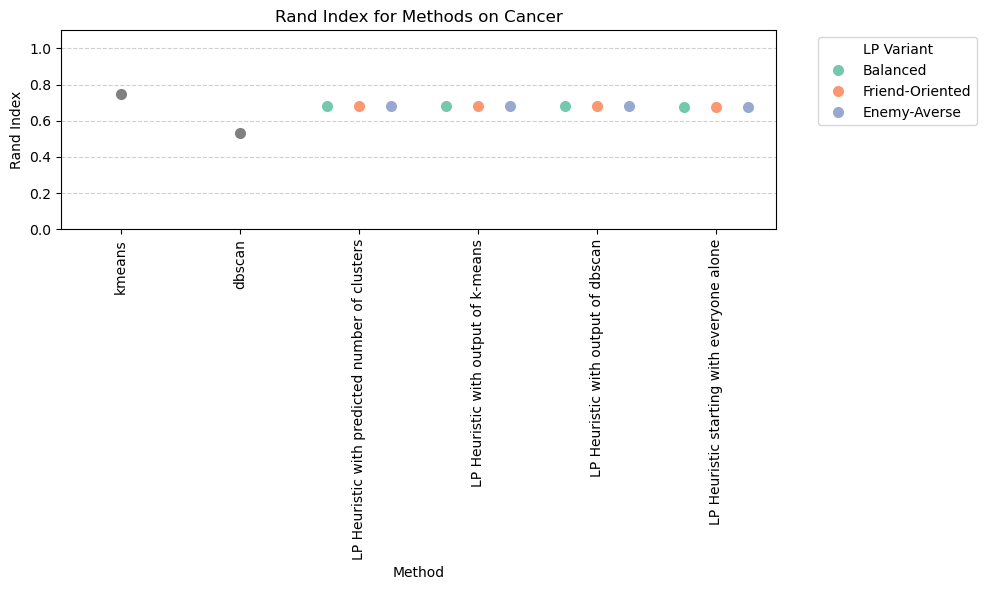

C:\Users\User\AppData\Local\Temp\ipykernel_9996\4105539467.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plot_score_by_method(sorted_df.replace("n.A.",0), Dataset, score_col=score, save_path=f'/Users/User/Downloads/local-popular-main-final/0202/{Dataset}-{score}.png')


Figure saved as /Users/User/Downloads/local-popular-main-final/0202/Cancer-Silhouette Score.png


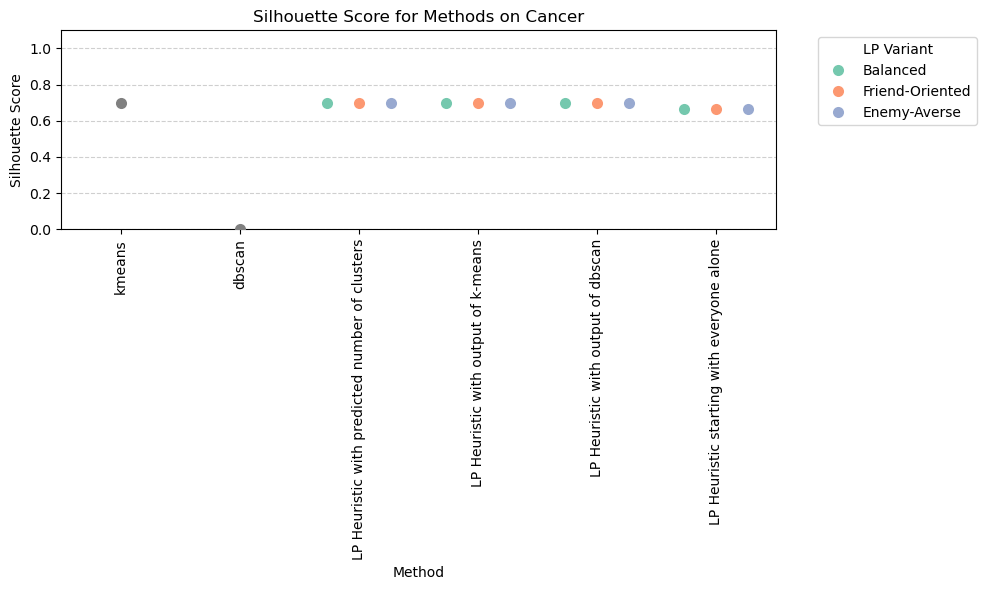

C:\Users\User\AppData\Local\Temp\ipykernel_9996\4105539467.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plot_score_by_method(sorted_df.replace("n.A.",0), Dataset, score_col=score, save_path=f'/Users/User/Downloads/local-popular-main-final/0202/{Dataset}-{score}.png')


Figure saved as /Users/User/Downloads/local-popular-main-final/0202/Cancer-Davies Bouldin Score.png


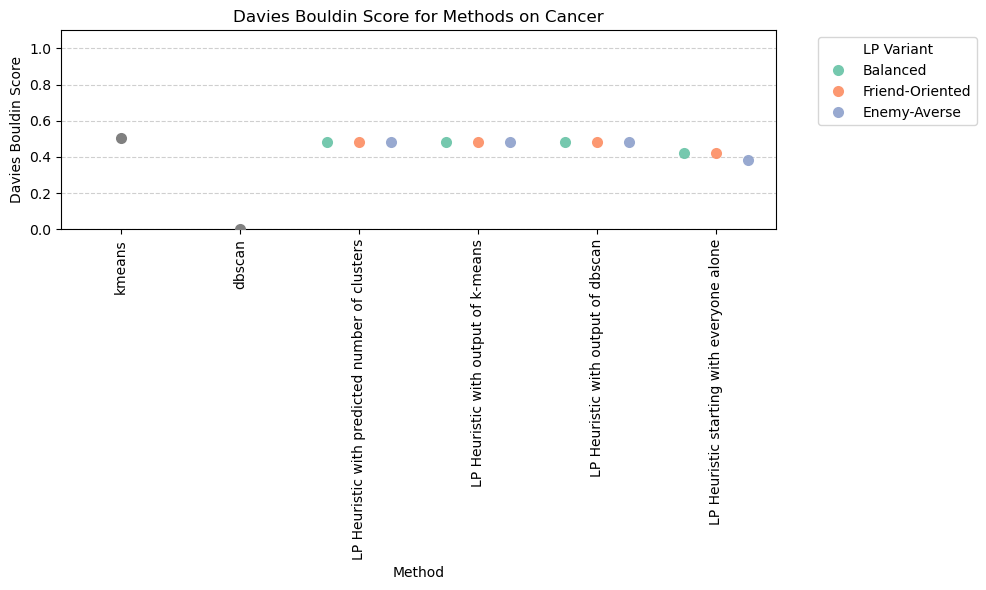

C:\Users\User\AppData\Local\Temp\ipykernel_9996\4105539467.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plot_score_by_method(sorted_df.replace("n.A.",0), Dataset, score_col=score, save_path=f'/Users/User/Downloads/local-popular-main-final/0202/{Dataset}-{score}.png')


Figure saved as /Users/User/Downloads/local-popular-main-final/0202/Iris-Rand Index.png


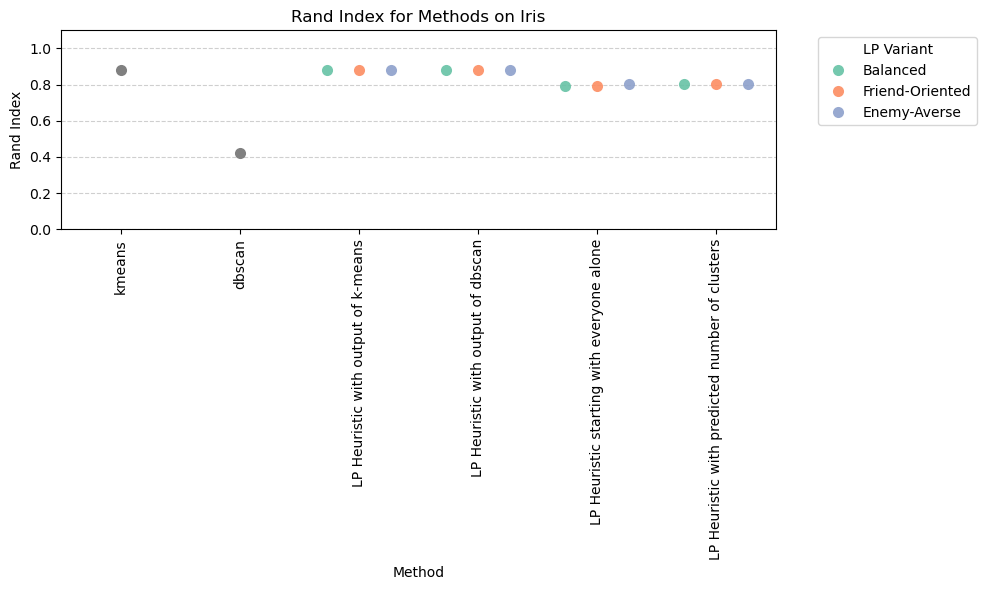

C:\Users\User\AppData\Local\Temp\ipykernel_9996\4105539467.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plot_score_by_method(sorted_df.replace("n.A.",0), Dataset, score_col=score, save_path=f'/Users/User/Downloads/local-popular-main-final/0202/{Dataset}-{score}.png')


Figure saved as /Users/User/Downloads/local-popular-main-final/0202/Iris-Silhouette Score.png


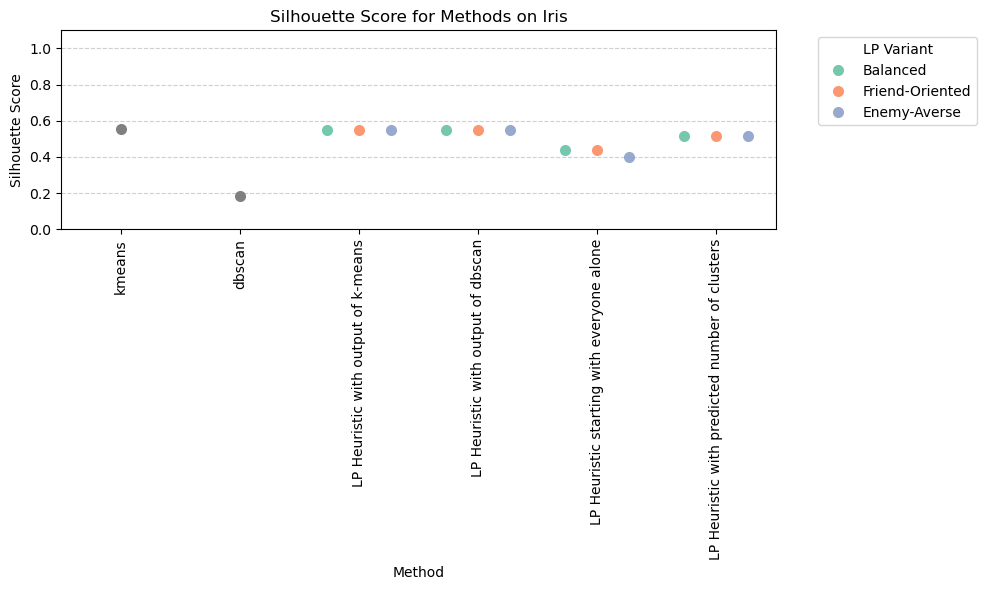

C:\Users\User\AppData\Local\Temp\ipykernel_9996\4105539467.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plot_score_by_method(sorted_df.replace("n.A.",0), Dataset, score_col=score, save_path=f'/Users/User/Downloads/local-popular-main-final/0202/{Dataset}-{score}.png')


Figure saved as /Users/User/Downloads/local-popular-main-final/0202/Iris-Davies Bouldin Score.png


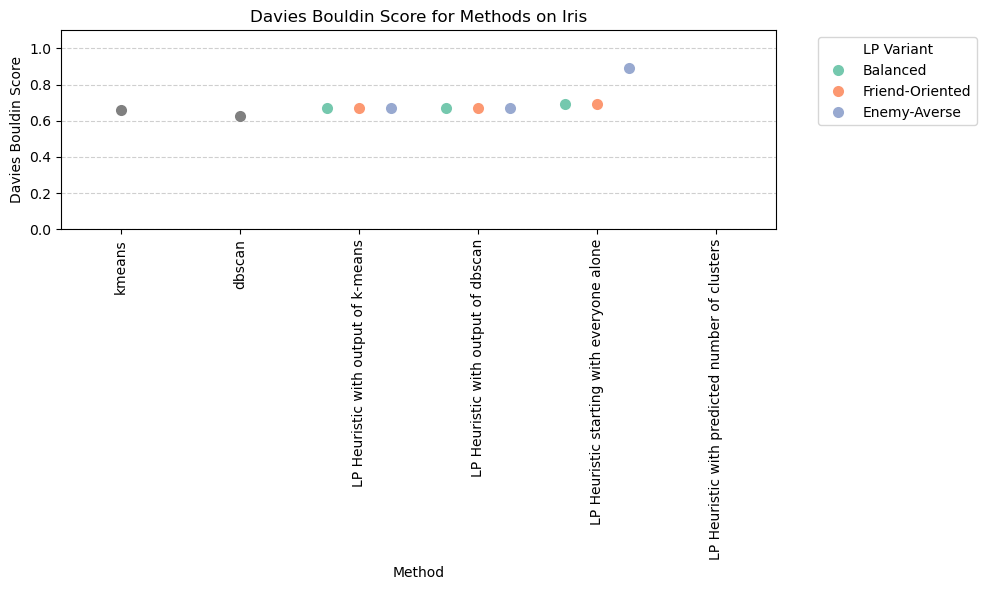

C:\Users\User\AppData\Local\Temp\ipykernel_9996\4105539467.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plot_score_by_method(sorted_df.replace("n.A.",0), Dataset, score_col=score, save_path=f'/Users/User/Downloads/local-popular-main-final/0202/{Dataset}-{score}.png')


Figure saved as /Users/User/Downloads/local-popular-main-final/0202/Moons-Rand Index.png


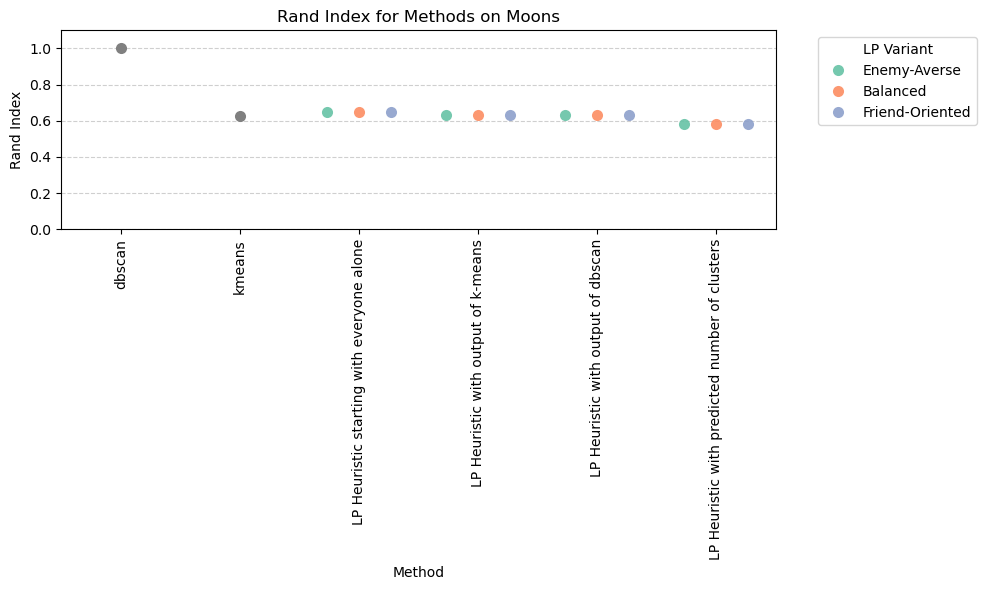

C:\Users\User\AppData\Local\Temp\ipykernel_9996\4105539467.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plot_score_by_method(sorted_df.replace("n.A.",0), Dataset, score_col=score, save_path=f'/Users/User/Downloads/local-popular-main-final/0202/{Dataset}-{score}.png')


Figure saved as /Users/User/Downloads/local-popular-main-final/0202/Moons-Silhouette Score.png


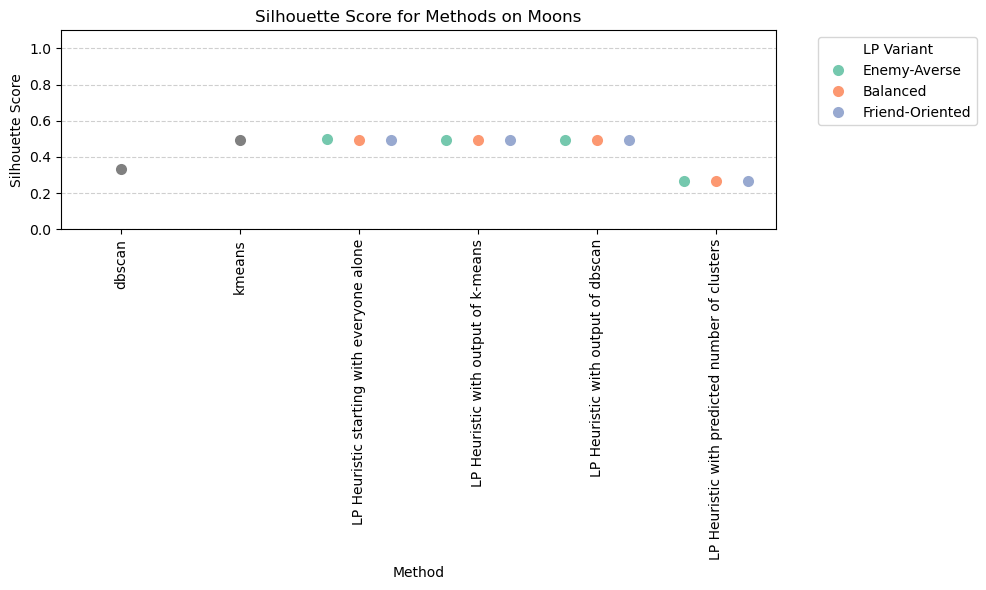

C:\Users\User\AppData\Local\Temp\ipykernel_9996\4105539467.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plot_score_by_method(sorted_df.replace("n.A.",0), Dataset, score_col=score, save_path=f'/Users/User/Downloads/local-popular-main-final/0202/{Dataset}-{score}.png')


Figure saved as /Users/User/Downloads/local-popular-main-final/0202/Moons-Davies Bouldin Score.png


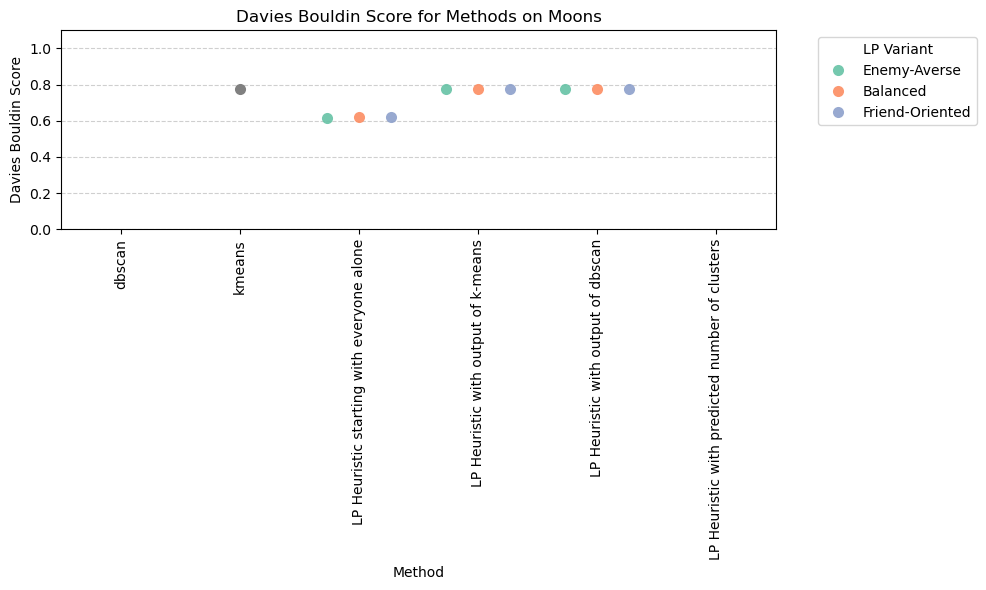

C:\Users\User\AppData\Local\Temp\ipykernel_9996\4105539467.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plot_score_by_method(sorted_df.replace("n.A.",0), Dataset, score_col=score, save_path=f'/Users/User/Downloads/local-popular-main-final/0202/{Dataset}-{score}.png')


Figure saved as /Users/User/Downloads/local-popular-main-final/0202/My 3 Circles-Rand Index.png


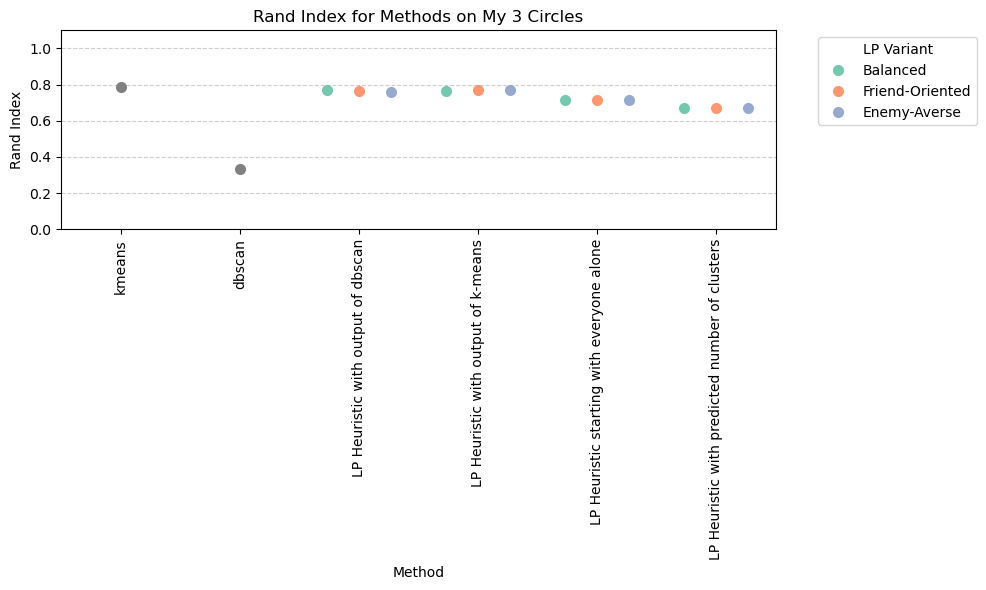

C:\Users\User\AppData\Local\Temp\ipykernel_9996\4105539467.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plot_score_by_method(sorted_df.replace("n.A.",0), Dataset, score_col=score, save_path=f'/Users/User/Downloads/local-popular-main-final/0202/{Dataset}-{score}.png')


Figure saved as /Users/User/Downloads/local-popular-main-final/0202/My 3 Circles-Silhouette Score.png


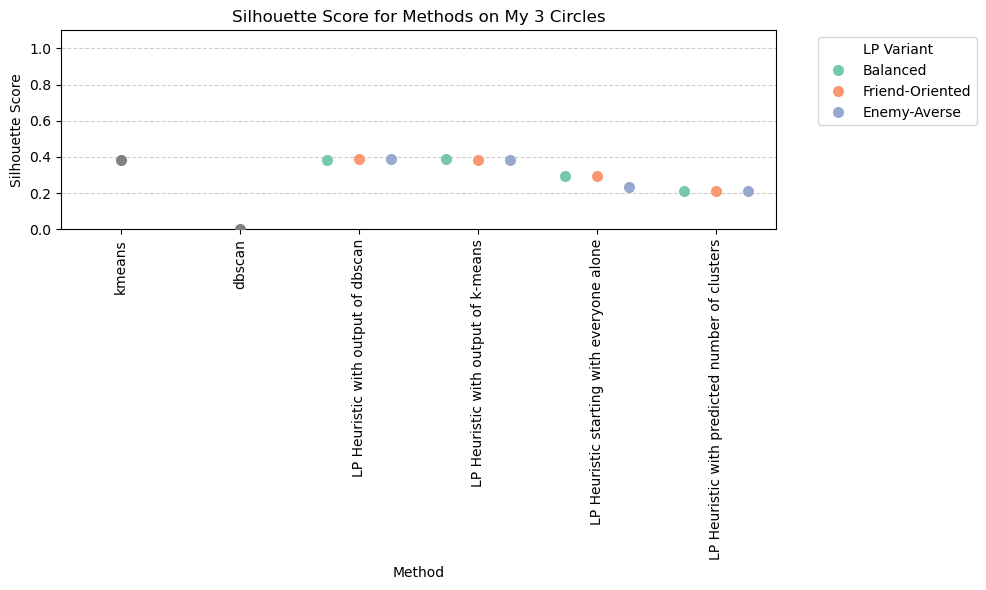

C:\Users\User\AppData\Local\Temp\ipykernel_9996\4105539467.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plot_score_by_method(sorted_df.replace("n.A.",0), Dataset, score_col=score, save_path=f'/Users/User/Downloads/local-popular-main-final/0202/{Dataset}-{score}.png')


Figure saved as /Users/User/Downloads/local-popular-main-final/0202/My 3 Circles-Davies Bouldin Score.png


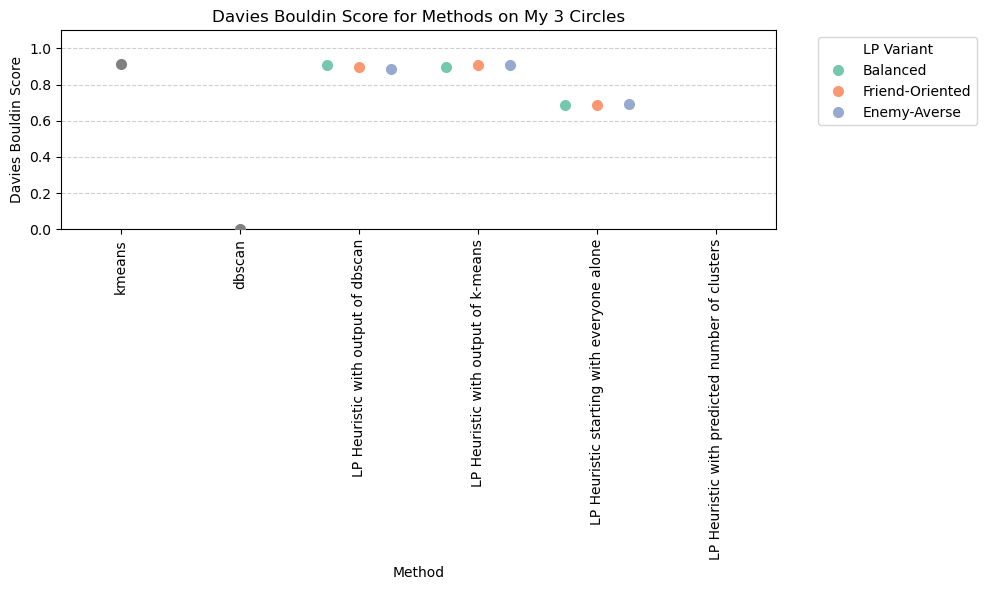

In [62]:
for Dataset in ['Cancer' ,'Iris', 'Moons' ,'My 3 Circles']:
    for score in ['Rand Index', 'Silhouette Score', 'Davies Bouldin Score']:
        plot_score_by_method(sorted_df.replace("n.A.",0), Dataset, score_col=score, save_path=f'/Users/User/Downloads/local-popular-main-final/0202/{Dataset}-{score}.png')

In [63]:
import itertools
import timeit

f = 0.4   #f-bound
e = 0.4   #e-bound

data = [ moon_perm_agents,circle_perm_agents,cancer_perm_agents,iris_perm_agents]
expected_clusters = [2,3,2,3]
graph_names = ['Moons','My 3 Circles', 'Cancer', 'Iris']
graph_truths =  [moon_perm_truth,circle_perm_truth,cancer_perm_truth,iris_perm_truth]


kmeans = lambda agents, clusters: KMeans(n_clusters = clusters).fit_predict(agents)
dbscan = lambda agents, clusters: DBSCAN(eps=0.2, min_samples=5).fit_predict(agents)

kmeans_out = None
dbscan_out = None

lp_a_b =lambda agents, initial_clustering, pre: locally_stable_clustering_with_euclid_graphs(agents, f, e, initial_clustering,mode='B',pre=pre)
lp_a_f =lambda agents, initial_clustering, pre: locally_stable_clustering_with_euclid_graphs(agents, f, e, initial_clustering,mode='F',pre=pre)
lp_a_e =lambda agents, initial_clustering, pre: locally_stable_clustering_with_euclid_graphs(agents, f, e, initial_clustering,mode='E',pre=pre)

algorithms = [ kmeans, dbscan,lp_a_b,lp_a_f,lp_a_e]
algo_names = [ 'kmeans', 'dbscan','LP (Balanced) Heuristic',\
               'LP (Friend-Oriented) Heuristic','LP (Enemy-Averse) Heuristic']
is_lp_heuristic = [False,False,True, True, True]

collected_data = {}

for ((graph, g_name,clusters,truth), (algo, a_name,lp_heuristic)) in \
    itertools.product(zip(data, graph_names, expected_clusters,graph_truths), zip(algorithms, algo_names,is_lp_heuristic)):

        
    agents = graph

    if lp_heuristic:
        # start with everyone alone
        a_name_modified = a_name + ' starting with everyone alone'
        print(f"Running {a_name_modified} on {g_name} … ", end='')
        test_callable = lambda a: list(algo(a,len(agents[0]),None).values())
        times,outputs = time_tester(test_callable,graph)
        avg_time = sum(times)/len(times)
        scores = calculate_scores_clustering(outputs,truth,agents)
        scores['Time'] = avg_time

        collected_data[(a_name_modified,g_name)] = scores
        print(f"execution time: ~ {avg_time:.6f} seconds.")
        for score_name in scores.keys():
            print(score_name,": ~",scores.get(score_name))

        # start with random clustering 

        a_name_modified = a_name + ' starting with predicted number of clusters'
        print(f"Running {a_name_modified} on {g_name} … ", end='')
        test_callable = lambda a: list(algo(a,clusters,None).values())
        times,outputs = time_tester(test_callable,graph)
        avg_time = sum(times)/len(times)
        scores = calculate_scores_clustering(outputs,truth,agents)
        scores['Time'] = avg_time

        collected_data[(a_name_modified,g_name)] = scores
        print(f"execution time: ~ {avg_time:.6f} seconds.")
        for score_name in scores.keys():
            print(score_name,": ~",scores.get(score_name))


        # start with the output of k-means
        a_name_modified = a_name + ' starting with the output of k-means'
        print(f"Running {a_name_modified} on {g_name} … ", end='')
        test_callable = lambda a: list(algo(a,clusters,kmeans).values())
        times,outputs = time_tester(test_callable,graph)
        avg_time = sum(times)/len(times)
        scores = calculate_scores_clustering(outputs,truth,agents)

        rand_score_with_init = sum(rand_score(out, k) for out, k in zip(outputs, kmeans_out)) / len(outputs)
        scores['Rand Score with initial clustering'] = rand_score_with_init
        
        scores['Time'] = avg_time

        collected_data[(a_name_modified,g_name)] = scores
        print(f"execution time: ~ {avg_time:.6f} seconds.")
        for score_name in scores.keys():
            print(score_name,": ~",scores.get(score_name))

        # start with the output of dbscan
        a_name_modified = a_name + ' starting with the output of dbscan'
        print(f"Running {a_name_modified} on {g_name} … ", end='')
        test_callable = lambda a: list(algo(a,clusters,dbscan).values())
        times,outputs = time_tester(test_callable,graph)
        avg_time = sum(times)/len(times)
        scores = calculate_scores_clustering(outputs,truth,agents)
        
        rand_score_with_init = sum(rand_score(out, db) for out, db in zip(outputs, dbscan_out)) / len(outputs)
        scores['Rand Score with initial clustering'] = rand_score_with_init
        

        scores['Time'] = avg_time

        collected_data[(a_name_modified,g_name)] = scores
        print(f"execution time: ~ {avg_time:.6f} seconds.")
        for score_name in scores.keys():
            print(score_name,": ~",scores.get(score_name))

            
    else:

        print(f"Running {a_name} on {g_name} … ", end='')
        test_callable = lambda a : algo(a, clusters)
            
        times,outputs = time_tester(test_callable,graph)
        if(algo == kmeans):
            kmeans_out = outputs
        if(algo == dbscan):
            dbscan_out = outputs
        avg_time = sum(times)/len(times)
        scores = calculate_scores_clustering(outputs,truth,agents)
        scores['Time'] = avg_time
        
        collected_data[(a_name,g_name)] = scores
        print(f"execution time: ~ {avg_time:.6f} seconds.")
        for score_name in scores.keys():
            print(score_name,": ~",scores.get(score_name))



Running kmeans on Moons … execution time: ~ 0.005752 seconds.
Rand Index : ~ 0.6374804905239688
Silhouette Score : ~ 0.4923323586872313
Davies Bouldin Score : ~ 0.7774254137626331
Time : ~ 0.005752100005338434
Running dbscan on Moons … execution time: ~ 0.002709 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.3317434708913247
Davies Bouldin Score : ~ 1.156549705433865
Time : ~ 0.0027093000026070513
Running LP (Balanced) Heuristic starting with everyone alone on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.142215 seconds.
Rand Index : ~ 0.6374804905239688
Silhouette Score : ~ 0.4923323586872313
Davies Bouldin Score : ~ 0.7774254137626331
Time : ~ 8.142214599996805
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.475964 seconds.
Rand Index : ~ 0.6374804905239688
Silhouette Score : ~ 0.4923323586872313
Davies Bouldin Score : ~ 0.7774254137626331
Time : ~ 0.475964400000521
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.469101 seconds.
Rand Index : ~ 0.6374804905239688
Silhouette Score : ~ 0.4923323586872313
Davies Bouldin Score : ~ 0.7774254137626331
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.4691012000039336
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.458425 seconds.
Rand Index : ~ 0.6374804905239688
Silhouette Score : ~ 0.4923323586872313
Davies Bouldin Score : ~ 0.7774254137626331
Time : ~ 0.4584251999986009
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 7.825678 seconds.
Rand Index : ~ 0.6374804905239688
Silhouette Score : ~ 0.4923323586872313
Davies Bouldin Score : ~ 0.7774254137626331
Time : ~ 7.825677599998016
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.472331 seconds.
Rand Index : ~ 0.6374804905239688
Silhouette Score : ~ 0.4923323586872313
Davies Bouldin Score : ~ 0.7774254137626331
Time : ~ 0.4723310000044876
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.435101 seconds.
Rand Index : ~ 0.6374804905239688
Silhouette Score : ~ 0.4923323586872313
Davies Bouldin Score : ~ 0.7774254137626331
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.4351005999997142
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.422002 seconds.
Rand Index : ~ 0.6374804905239688
Silhouette Score : ~ 0.4923323586872313
Davies Bouldin Score : ~ 0.7774254137626331
Time : ~ 0.4220019999993383
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 7.948104 seconds.
Rand Index : ~ 0.6374804905239688
Silhouette Score : ~ 0.4923323586872313
Davies Bouldin Score : ~ 0.7774254137626331
Time : ~ 7.948104199997033
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.459267 seconds.
Rand Index : ~ 0.6374804905239688
Silhouette Score : ~ 0.4923323586872313
Davies Bouldin Score : ~ 0.7774254137626331
Time : ~ 0.4592670999991242
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.460026 seconds.
Rand Index : ~ 0.6374804905239688
Silhouette Score : ~ 0.4923323586872313
Davies Bouldin Score : ~ 0.7774254137626331
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.46002559999760706
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.457013 seconds.
Rand Index : ~ 0.6374804905239688
Silhouette Score : ~ 0.4923323586872313
Davies Bouldin Score : ~ 0.7774254137626331
Time : ~ 0.45701289999851724
Running kmeans on My 3 Circles … execution time: ~ 0.005170 seconds.
Rand Index : ~ 0.7560535117056856
Silhouette Score : ~ 0.398399108640848
Davies Bouldin Score : ~ 0.8713215753687269
Time : ~ 0.005169500000192784
Running dbscan on My 3 Circles … execution time: ~ 0.003242 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.003241600003093481
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.020025 seconds.
Rand Index : ~ 0.7375473801560758
Silhouette Score : ~ 0.4961265315732956
Davies Bouldin Score : ~ 0.7328532478120995
Time : ~ 8.0200249000045
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.575670 seconds.
Rand Index : ~ 0.7352285395763657
Silhouette Score : ~ 0.49663519265577133
Davies Bouldin Score : ~ 0.7350879123500637
Time : ~ 0.5756703000006382
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.609973 seconds.
Rand Index : ~ 0.7375473801560758
Silhouette Score : ~ 0.4961265315732956
Davies Bouldin Score : ~ 0.7328532478120995
Rand Score with initial clustering : ~ 0.7309253065774804
Time : ~ 0.6099733000010019
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.596223 seconds.
Rand Index : ~ 0.7352285395763657
Silhouette Score : ~ 0.49663519265577133
Davies Bouldin Score : ~ 0.7350879123500637
Time : ~ 0.5962232000019867
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.586105 seconds.
Rand Index : ~ 0.7427201783723523
Silhouette Score : ~ 0.49466816883736253
Davies Bouldin Score : ~ 0.7294768002619338
Time : ~ 7.586104599999089
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.487756 seconds.
Rand Index : ~ 0.7352285395763657
Silhouette Score : ~ 0.49663519265577133
Davies Bouldin Score : ~ 0.7350879123500637
Time : ~ 0.4877559000015026
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.467850 seconds.
Rand Index : ~ 0.7352285395763657
Silhouette Score : ~ 0.49663519265577133
Davies Bouldin Score : ~ 0.7350879123500637
Rand Score with initial clustering : ~ 0.7344927536231884
Time : ~ 0.4678496999986237
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.480670 seconds.
Rand Index : ~ 0.7375473801560758
Silhouette Score : ~ 0.4961265315732956
Davies Bouldin Score : ~ 0.7328532478120995
Time : ~ 0.4806696999949054
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.935032 seconds.
Rand Index : ~ 0.7375473801560758
Silhouette Score : ~ 0.4961265315732956
Davies Bouldin Score : ~ 0.7328532478120995
Time : ~ 7.935031900000467
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.486491 seconds.
Rand Index : ~ 0.7352285395763657
Silhouette Score : ~ 0.49663519265577133
Davies Bouldin Score : ~ 0.7350879123500637
Time : ~ 0.48649110000405926
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.495765 seconds.
Rand Index : ~ 0.7375473801560758
Silhouette Score : ~ 0.4961265315732956
Davies Bouldin Score : ~ 0.7328532478120995
Rand Score with initial clustering : ~ 0.7309253065774804
Time : ~ 0.49576539999543456
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.438397 seconds.
Rand Index : ~ 0.7375473801560758
Silhouette Score : ~ 0.4961265315732956
Davies Bouldin Score : ~ 0.7328532478120995
Time : ~ 0.4383968000038294
Running kmeans on Cancer … execution time: ~ 0.006268 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059465
Davies Bouldin Score : ~ 0.504403568541099
Time : ~ 0.006268099998123944
Running dbscan on Cancer … execution time: ~ 0.004668 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.004667900000640657
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 55.805037 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233511
Time : ~ 55.80503719999979
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.478381 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233511
Time : ~ 1.4783807000058005
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.900342 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233511
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.9003415999977733
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.696735 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233511
Time : ~ 1.6967353000000003
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 59.479375 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233511
Time : ~ 59.479374700000335
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.843781 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233511
Time : ~ 1.8437809000024572
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.748488 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233511
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.7484884000004968
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.773865 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233511
Time : ~ 1.7738654000058887
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 52.876268 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233511
Time : ~ 52.87626799999998
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.403605 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233511
Time : ~ 1.4036054000025615
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.755059 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233511
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.7550594999993336
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.659171 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233511
Time : ~ 1.6591711000000942
Running kmeans on Iris … execution time: ~ 0.004196 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007493
Time : ~ 0.0041962000032071956
Running dbscan on Iris … execution time: ~ 0.001833 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.18256428323870083
Davies Bouldin Score : ~ 0.6275995822540158
Time : ~ 0.001833399997849483
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.794209 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519143
Time : ~ 0.7942089999996824
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.159320 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519143
Time : ~ 0.15932020000036573
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.156229 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519143
Rand Score with initial clustering : ~ 0.7641163310961969
Time : ~ 0.1562292000016896
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.152700 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519143
Time : ~ 0.15270040000177687
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.071469 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519143
Time : ~ 1.0714690000022529
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.154473 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117462
Davies Bouldin Score : ~ 0.404292837173

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.162332 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117462
Davies Bouldin Score : ~ 0.40429283717304115
Rand Score with initial clustering : ~ 0.7701118568232662
Time : ~ 0.162331899999117
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.141654 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117462
Davies Bouldin Score : ~ 0.40429283717304115
Time : ~ 0.14165430000139168
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.132916 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519143
Time : ~ 1.1329157000000123
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.151914 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.414527784265

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.157774 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519143
Rand Score with initial clustering : ~ 0.7641163310961969
Time : ~ 0.1577735000028042
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.158125 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519143
Time : ~ 0.15812450000521494


In [64]:
import pandas as pd
records = []
for (method, dataset), metrics in collected_data.items():
    record = {'Method': method, 'Dataset': dataset}
    record.update(metrics)
    records.append(record)

df = pd.DataFrame(records)

# Example usage:
sorted_df = sort_within_datasets(df, 'Rand Index', ascending=False)
sorted_df

,Method,Dataset,Rand Index,Silhouette Score,Davies Bouldin Score,Time,Rand Score with initial clustering
28,kmeans,Cancer,0.750377,0.697265,0.504404,0.006268,NaN
30,LP (Balanced) Heuristic starting with everyone...,Cancer,0.547588,0.701944,0.401243,55.805037,NaN
31,LP (Balanced) Heuristic starting with predicte...,Cancer,0.547588,0.701944,0.401243,1.478381,NaN
32,LP (Balanced) Heuristic starting with the outp...,Cancer,0.547588,0.701944,0.401243,1.900342,0.945246
33,LP (Balanced) Heuristic starting with the outp...,Cancer,0.547588,0.701944,0.401243,1.696735,NaN
34,LP (Friend-Oriented) Heuristic starting with e...,Cancer,0.547588,0.701944,0.401243,59.479375,NaN
35,LP (Friend-Oriented) Heuristic starting with p...,Cancer,0.547588,0.701944,0.401243,1.843781,NaN
36,LP (Friend-Oriented) Heuristic starting with t...,Cancer,0.547588,0.701944,0.401243,1.748488,0.945246
37,LP (Friend-Oriented) Heuristic starting with t...,Cancer,0.547588,0.701944,0.401243,1.773865,NaN
38,LP (Enemy-Averse) Heuristic starting with ever...,Cancer,0.547588,0.701944,0.401243,52.876268,NaN


C:\Users\User\AppData\Local\Temp\ipykernel_9996\1392601226.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plot_score_by_method(sorted_df.replace("n.A.",0), Dataset, score_col=score, save_path=f'/Users/User/Downloads/local-popular-main-final/0404/{Dataset}-{score}.png')


Figure saved as /Users/User/Downloads/local-popular-main-final/0404/Cancer-Rand Index.png


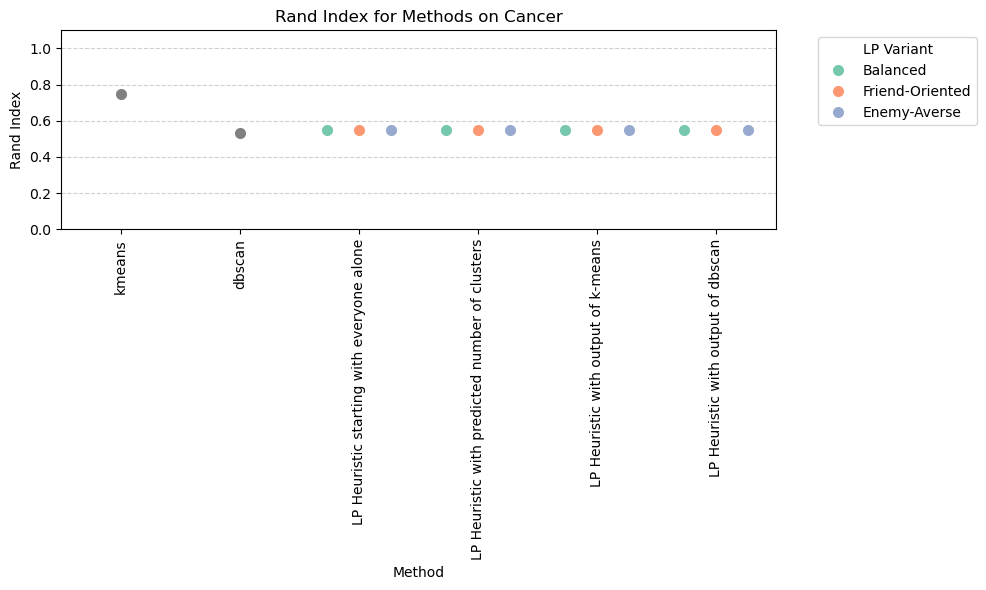

C:\Users\User\AppData\Local\Temp\ipykernel_9996\1392601226.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plot_score_by_method(sorted_df.replace("n.A.",0), Dataset, score_col=score, save_path=f'/Users/User/Downloads/local-popular-main-final/0404/{Dataset}-{score}.png')


Figure saved as /Users/User/Downloads/local-popular-main-final/0404/Cancer-Silhouette Score.png


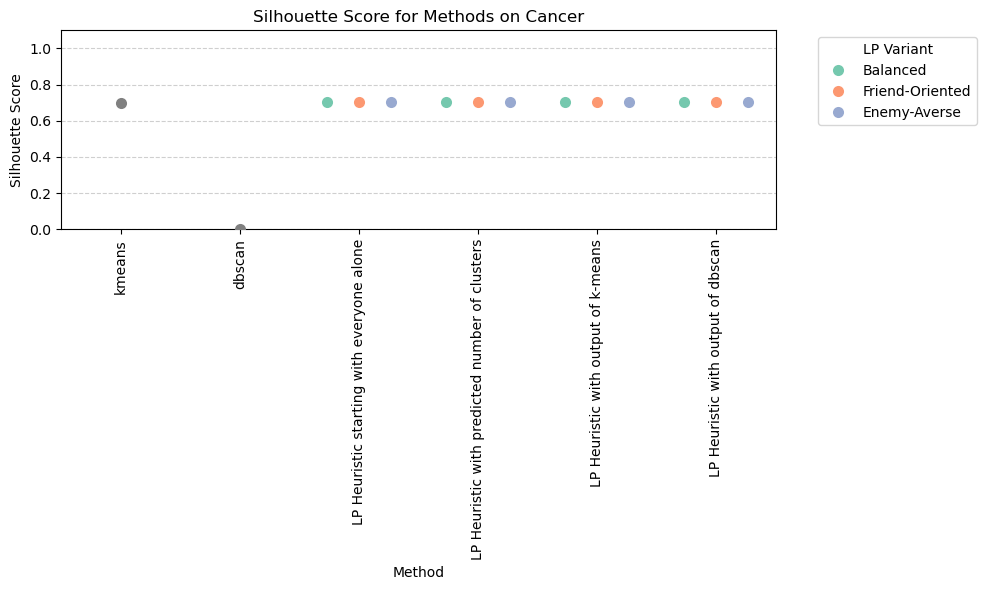

C:\Users\User\AppData\Local\Temp\ipykernel_9996\1392601226.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plot_score_by_method(sorted_df.replace("n.A.",0), Dataset, score_col=score, save_path=f'/Users/User/Downloads/local-popular-main-final/0404/{Dataset}-{score}.png')


Figure saved as /Users/User/Downloads/local-popular-main-final/0404/Cancer-Davies Bouldin Score.png


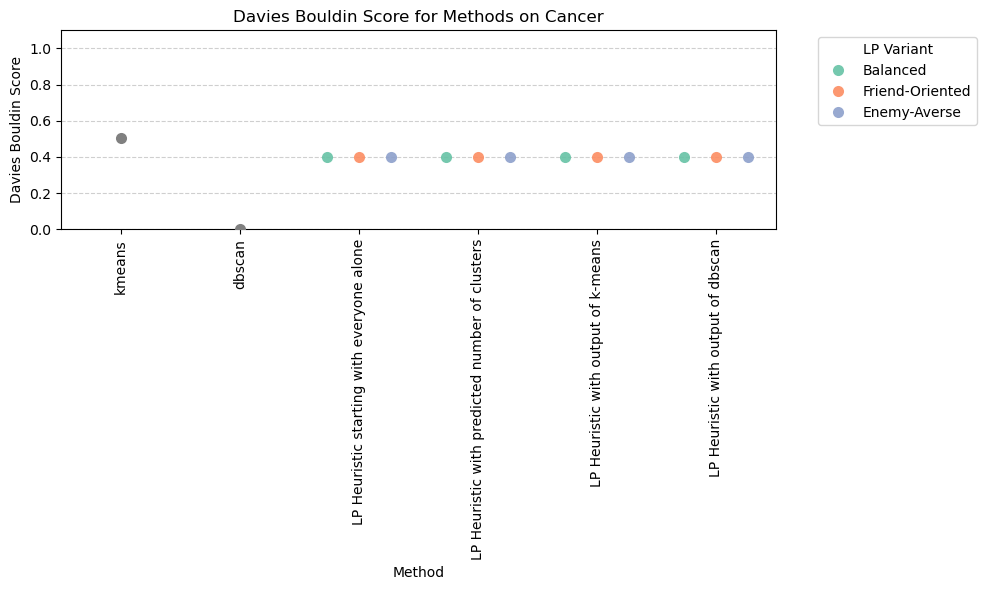

C:\Users\User\AppData\Local\Temp\ipykernel_9996\1392601226.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plot_score_by_method(sorted_df.replace("n.A.",0), Dataset, score_col=score, save_path=f'/Users/User/Downloads/local-popular-main-final/0404/{Dataset}-{score}.png')


Figure saved as /Users/User/Downloads/local-popular-main-final/0404/Iris-Rand Index.png


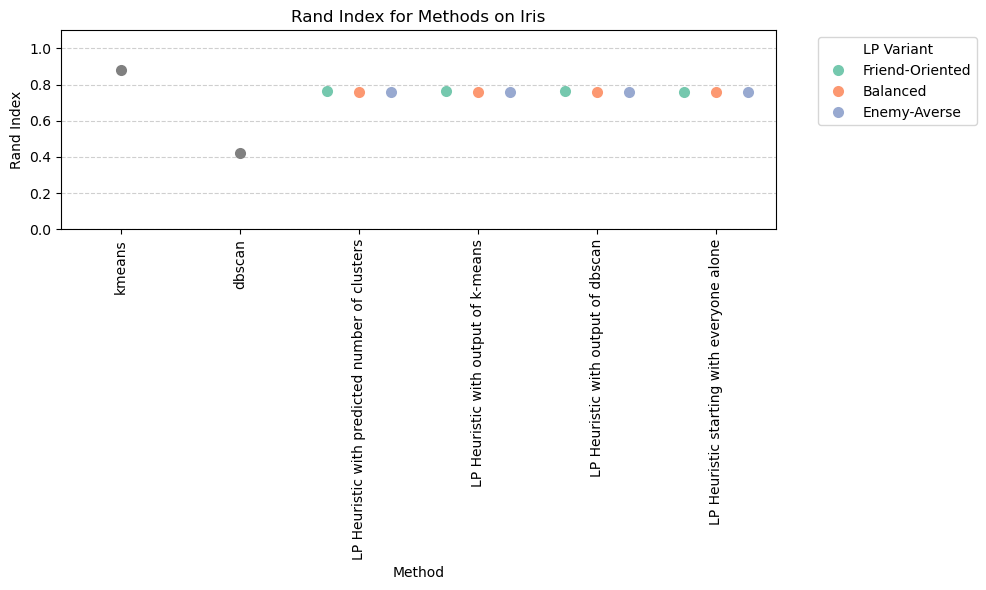

C:\Users\User\AppData\Local\Temp\ipykernel_9996\1392601226.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plot_score_by_method(sorted_df.replace("n.A.",0), Dataset, score_col=score, save_path=f'/Users/User/Downloads/local-popular-main-final/0404/{Dataset}-{score}.png')


Figure saved as /Users/User/Downloads/local-popular-main-final/0404/Iris-Silhouette Score.png


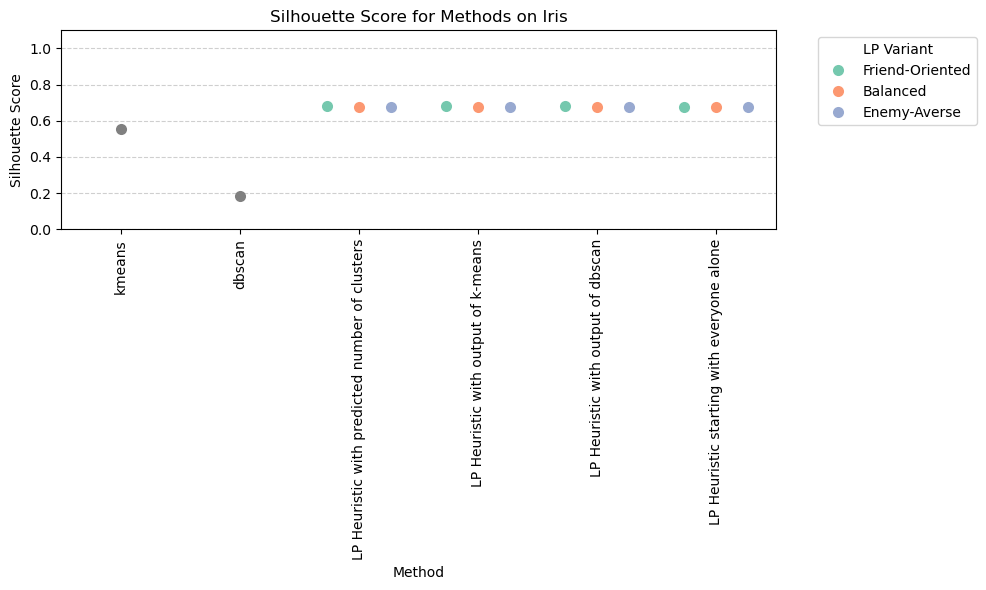

C:\Users\User\AppData\Local\Temp\ipykernel_9996\1392601226.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plot_score_by_method(sorted_df.replace("n.A.",0), Dataset, score_col=score, save_path=f'/Users/User/Downloads/local-popular-main-final/0404/{Dataset}-{score}.png')


Figure saved as /Users/User/Downloads/local-popular-main-final/0404/Iris-Davies Bouldin Score.png


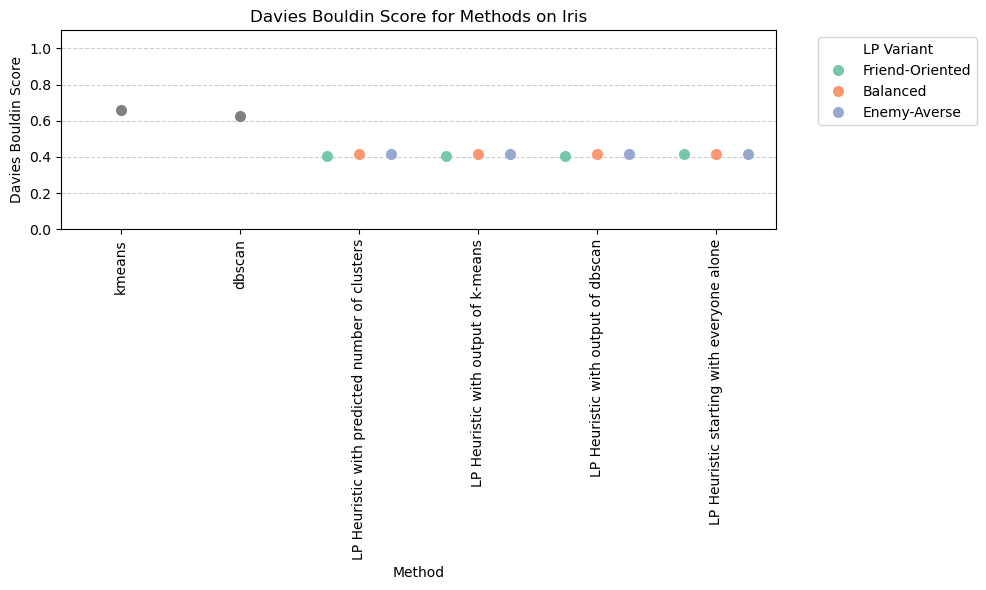

C:\Users\User\AppData\Local\Temp\ipykernel_9996\1392601226.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plot_score_by_method(sorted_df.replace("n.A.",0), Dataset, score_col=score, save_path=f'/Users/User/Downloads/local-popular-main-final/0404/{Dataset}-{score}.png')


Figure saved as /Users/User/Downloads/local-popular-main-final/0404/Moons-Rand Index.png


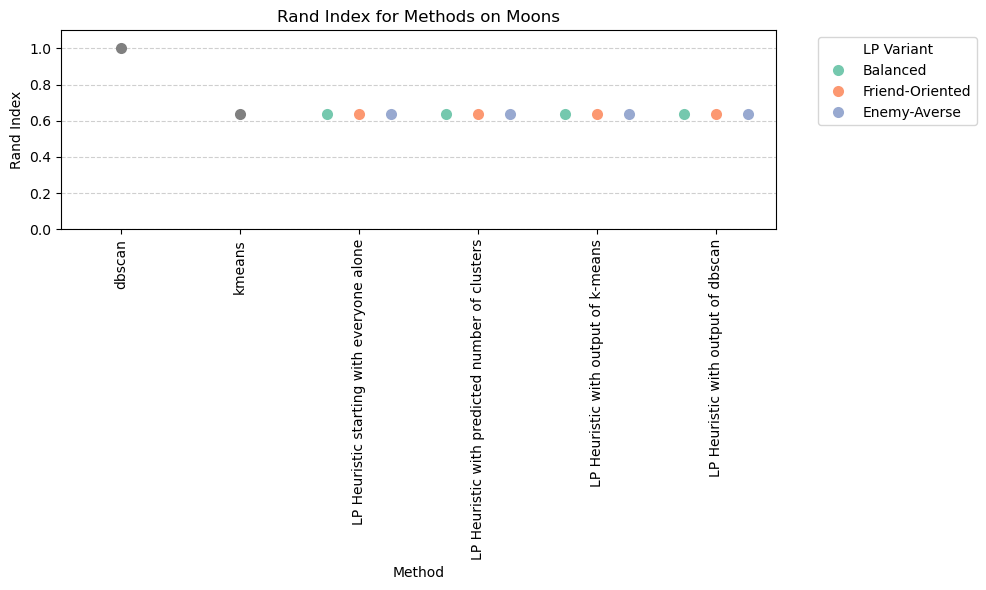

C:\Users\User\AppData\Local\Temp\ipykernel_9996\1392601226.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plot_score_by_method(sorted_df.replace("n.A.",0), Dataset, score_col=score, save_path=f'/Users/User/Downloads/local-popular-main-final/0404/{Dataset}-{score}.png')


Figure saved as /Users/User/Downloads/local-popular-main-final/0404/Moons-Silhouette Score.png


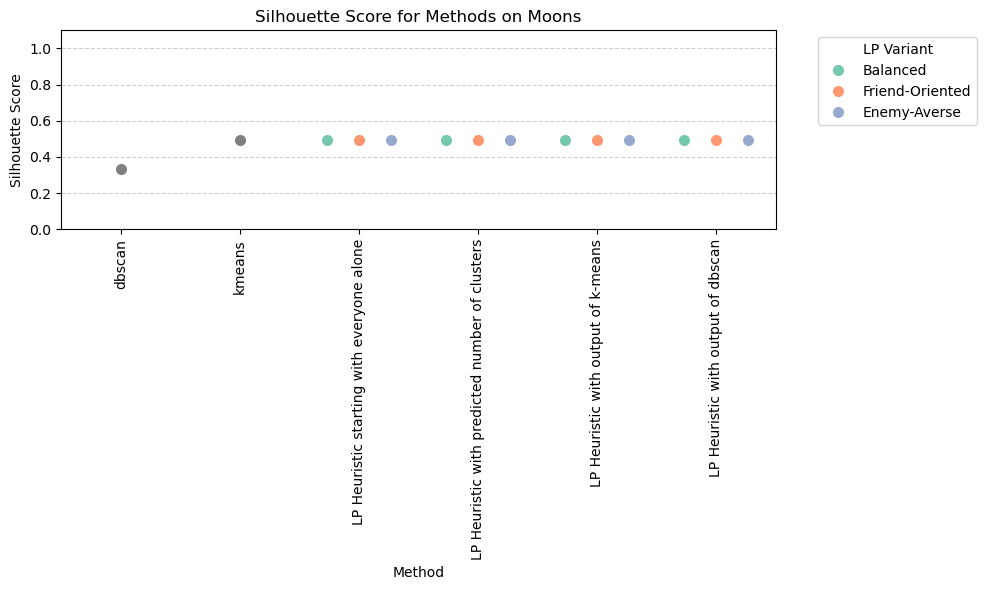

C:\Users\User\AppData\Local\Temp\ipykernel_9996\1392601226.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plot_score_by_method(sorted_df.replace("n.A.",0), Dataset, score_col=score, save_path=f'/Users/User/Downloads/local-popular-main-final/0404/{Dataset}-{score}.png')


Figure saved as /Users/User/Downloads/local-popular-main-final/0404/Moons-Davies Bouldin Score.png


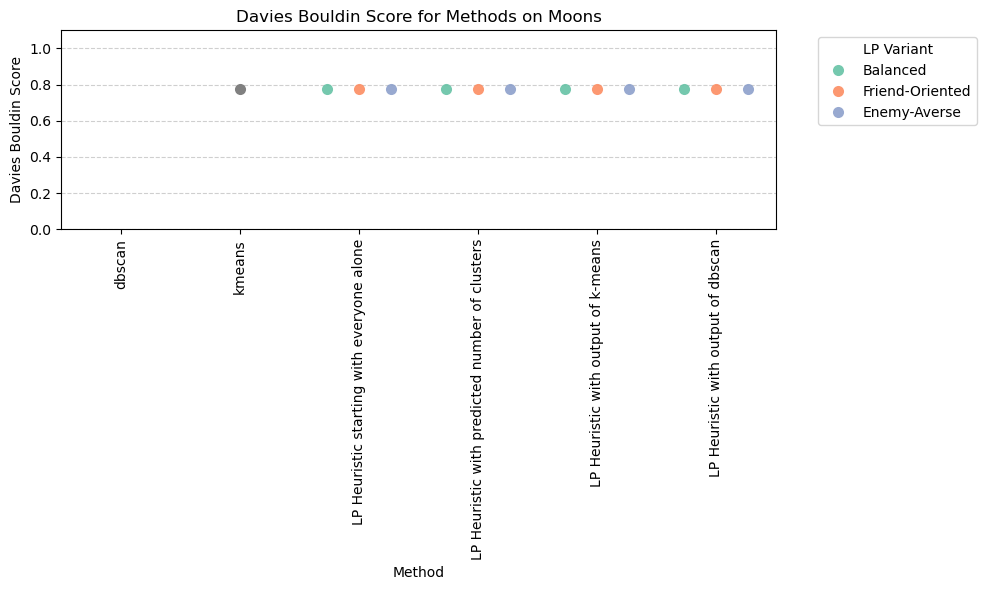

C:\Users\User\AppData\Local\Temp\ipykernel_9996\1392601226.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plot_score_by_method(sorted_df.replace("n.A.",0), Dataset, score_col=score, save_path=f'/Users/User/Downloads/local-popular-main-final/0404/{Dataset}-{score}.png')


Figure saved as /Users/User/Downloads/local-popular-main-final/0404/My 3 Circles-Rand Index.png


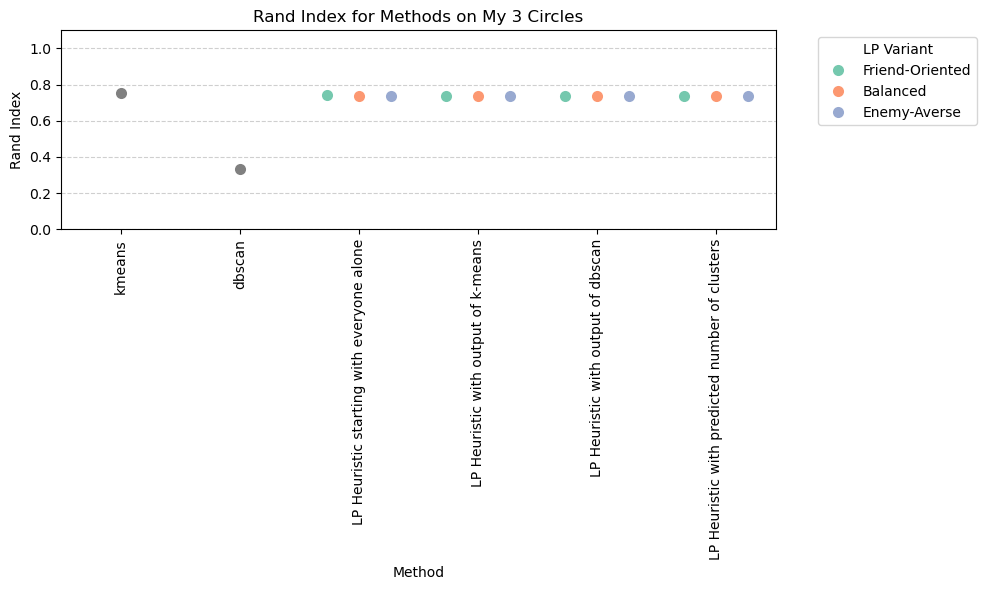

C:\Users\User\AppData\Local\Temp\ipykernel_9996\1392601226.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plot_score_by_method(sorted_df.replace("n.A.",0), Dataset, score_col=score, save_path=f'/Users/User/Downloads/local-popular-main-final/0404/{Dataset}-{score}.png')


Figure saved as /Users/User/Downloads/local-popular-main-final/0404/My 3 Circles-Silhouette Score.png


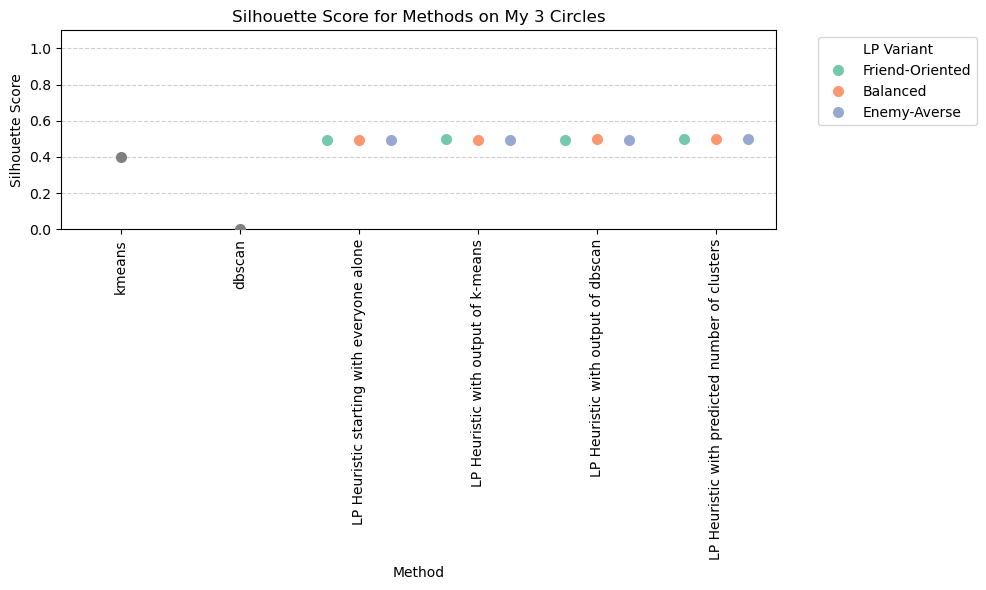

C:\Users\User\AppData\Local\Temp\ipykernel_9996\1392601226.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plot_score_by_method(sorted_df.replace("n.A.",0), Dataset, score_col=score, save_path=f'/Users/User/Downloads/local-popular-main-final/0404/{Dataset}-{score}.png')


Figure saved as /Users/User/Downloads/local-popular-main-final/0404/My 3 Circles-Davies Bouldin Score.png


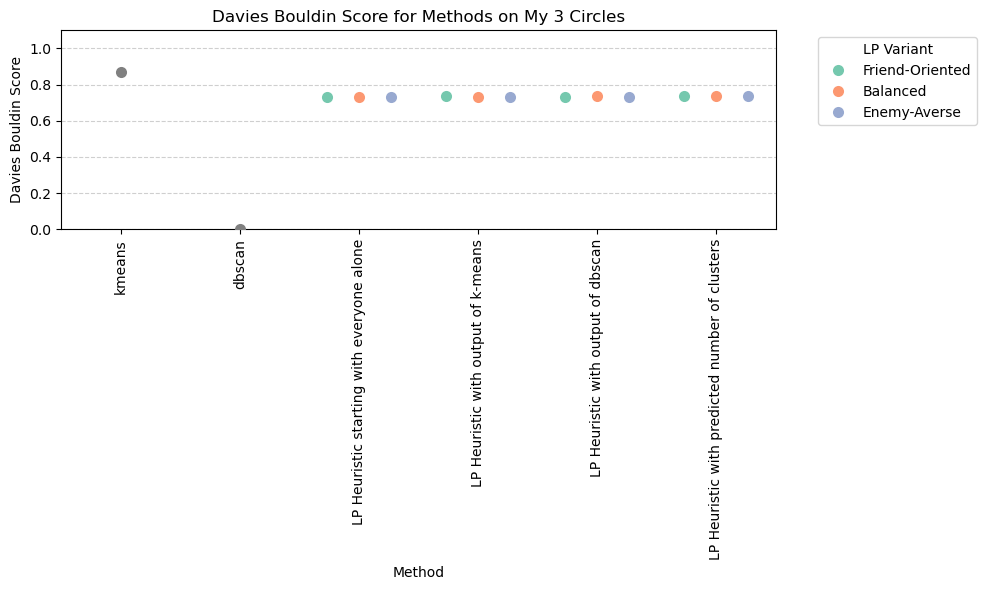

In [65]:
for Dataset in ['Cancer' ,'Iris', 'Moons' ,'My 3 Circles']:
    for score in ['Rand Index', 'Silhouette Score', 'Davies Bouldin Score']:
        plot_score_by_method(sorted_df.replace("n.A.",0), Dataset, score_col=score, save_path=f'/Users/User/Downloads/local-popular-main-final/0404/{Dataset}-{score}.png')